In [133]:
# Import the required packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, os
import bambi as bmb
import pymc as pm
import arviz as az
import scipy.stats as stat
from collections import Counter
import itertools
import hssm


In [134]:
#Set up plotting themes
sns.set_context('talk')
sns.set_style('darkgrid')

# Function to clean the data files

#### For each data file this function does the following:
1. Drops irrelevant columns
2. Computes accuracies (accurate if all correct keys pressed on the first try)
3. Label Node types: Boundary vs non boundary
4. Label transition types: Cross cluster or within cluster
4. Label other relevant conditions like walk length, number of keypresses, etc. 

In [135]:
def clean_data(filename, which_data = 'mem data', root_dir = 'source_mem_data'):
    # print(filename)
    # Handle errors. If there is an error, go to 'except' and return nothing.
    try:
        data = pd.read_csv(f'{root_dir}/{filename}')
    
        # Drop instruction rows by dropping rows with missing data in column: 'blocks.thisRepN'
        # data = data.dropna(subset=['trials.thisRepN']).reset_index(drop=True)
    
        #If data file is incomplete, raise an error. 
        #Label conditions based on participant number as was designed in the experiment
        if data['participant'][0]%2 == 0:
            data['condition'] = 'structured'
        else:
            data['condition'] = 'unstructured'
    
        # data['trial'] = np.arange(len(data))
        
        
        #filtering exposure data, removing rows with no path id
        exposure  = data.loc[data['path id'].notna(), ['trials.thisN', 'path id', 'stim chosen', 'key_resp.rt', 'key_resp.corr', 'condition']].reset_index(drop=True)
        exposure.rename(columns = {'trials.thisN': 'trials', 'key_resp.corr':'accuracy', 'key_resp.rt':'rt'}, inplace = True)
        #New column to define a block    
        exposure['block'] = np.repeat(np.arange(3), 250)
        #node types
        exposure['node type'] = 'nonboundary'
        exposure.loc[(exposure['path id'].isin([0, 4, 5, 9, 10, 14])), 'node type'] = 'boundary'
        exposure['participant'] = data['participant'][0]
        exposure['transition_type'] = ['cross cluster' if (exposure['node type'] == 'boundary')[i] & (exposure['node type'].shift() == 'boundary')[i] else 'within cluster' for i in range(len(exposure))]
    
        #extracting actual boundary vs non boundary stimuli files that were shown. 
        boundary_stim = exposure.loc[exposure['node type'] == 'boundary', 'stim chosen'].unique()
        nonboundary_stim = exposure.loc[exposure['node type'] == 'nonboundary', 'stim chosen'].unique()
        
        #Filtering memory data, removing rows with nothing in the 'old or new' column
        memory = data.loc[data['old or new'].notna(), ['mem_test_key_resp.rt', 'old or new', 'old or new accuracy', 'test item', 'condition']].reset_index(drop=True)
        memory['trials'] = np.arange(90)
        memory['block'] = np.repeat(np.arange(3), 30)
        #Node types
        memory['node type'] = 'new'
        #Testing whether if each test item is in the boundary stim list
        memory.loc[memory['test item'].isin(boundary_stim), 'node type'] = 'boundary'
        memory.loc[memory['test item'].isin(nonboundary_stim), 'node type'] = 'nonboundary'
        memory.rename(columns={'mem_test_key_resp.rt':'rt', 'old or new accuracy':'accuracy'}, inplace=True)
        #Translating string rts to numerical rts
        memory['rt'] = [ast.literal_eval(i)[0] for i in memory['rt']]
        memory['participant'] = data['participant'][0]
        
        
        path_border_map = data.groupby(['border color', 'path id']).count().reset_index()[['border color', 'path id']]
        data = data.dropna(subset=['source mem index']).reset_index(drop=True)
        data = data.dropna(axis=1, how='any')

        #If data file is incomplete, raise an error. 
        #Label conditions based on participant number as was designed in the experiment
        if data['participant'][0]%2 == 0:
            data['condition'] = 'structured'
        else:
            data['condition'] = 'unstructured'


        corr_answer = {'orange': 'left', 'green':'down', 'purple':'right'}
        source_mem = pd.merge(data[['participant', 'condition', 'source mem index', 'source_mem_key_resp.keys', 'source_mem_key_resp.rt']], path_border_map,  left_on=['source mem index'], right_on=['path id'])
        source_mem['corr_answer'] = [corr_answer[i] for i in source_mem['border color'].values]
        source_mem['accuracy'] = (source_mem['source_mem_key_resp.keys'] == source_mem['corr_answer']).astype(int)
        source_mem['node_type'] = 'nonboundary'
        source_mem.loc[(source_mem['path id'].isin([0, 4, 5, 9, 10, 14])), 'node_type'] = 'boundary'


    except:
        return None

    #Return the dataframe with relevant columns
    if which_data == 'mem data':
        return memory 
    elif which_data == 'source mem':
        return source_mem
    else:
        return exposure
        # return filtered_data.loc[filtered_data['old or new'].isna()].reset_index(drop=True)
        


# Read the data files

In [136]:
#reads in all the NAMES of the data files from the 'data' folder. 
data_files = []
for f in os.listdir('source_mem_data/'):
    if (f.startswith('24') & f.endswith('csv')):
        data_files.append(f)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'source_mem_data/'

# Cleaning the data files into a single large dataframe

1. Label Trials, conditions, etc. 
2. Combine relevant columns of extracted data files 
3. Specify outliers and remove them


In [ ]:
df_clean_exposure = pd.concat([clean_data(f, which_data='non mem data') for f in data_files]).reset_index(drop = True)
df_clean_source_mem = pd.concat([clean_data(f, which_data='source mem') for f in data_files]).reset_index(drop = True)
df_clean_memory = pd.concat([clean_data(f) for f in data_files]).reset_index(drop = True)

# df_clean['reset'] = 'False'
# df_clean.loc[df_clean['trial'].values%(df_clean['walk_length'].values+1) == 0, 'reset'] = 'True'



# df_clean_rt_outlier = df_clean[np.abs(stat.zscore(df_clean['rt'], nan_policy='omit')) < 3]
# df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']

# df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'graph identity', 'condition', 'test no']).mean(numeric_only = True).reset_index()

# # df_clean_rt_outlier['walk_length'] = df_clean_rt_outlier.walk_length.astype('str')
# # df_clean_rt_outlier['num_keypress'] = df_clean_rt_outlier['num_keypress'].astype(str)

# df_clean_participant

In [ ]:
df_clean_exposure.loc[df_clean_exposure.condition == 'unstructured'].participant.unique().shape

(30,)

In [ ]:
df_clean_memory['resp_old'] = 1
df_clean_memory.loc[((df_clean_memory['old or new'] == 'new') & df_clean_memory.accuracy), 'resp_old'] = 0
df_clean_memory.loc[((df_clean_memory['old or new'] == 'old') & (1 - df_clean_memory.accuracy)), 'resp_old'] = 0


df_clean_memory['response'] = df_clean_memory['resp_old'].astype(int)
df_clean_memory.loc[df_clean_memory.resp_old == 0, 'response'] = -1
# df_clean_memory['response'] = df_clean_memory['accuracy'].astype(int)
# df_clean_memory.loc[df_clean_memory.accuracy == 0, 'response'] = -1

df_clean_memory['node_type'] = df_clean_memory['node type']
df_clean_memory['participant_id'] = df_clean_memory['participant']


In [ ]:
df_clean_exposure_grouped = df_clean_exposure.groupby(['stim chosen', 'participant', 'block']).mean(numeric_only=True).reset_index()
df_clean_exposure_acc = df_clean_exposure_grouped.groupby(['participant', 'block']).mean(numeric_only=True).reset_index()

#Join first to incorporate exposure accuracy for old stimuli
df_clean_memory_joined = pd.merge(df_clean_memory, df_clean_exposure_grouped, left_on=['participant', 'test item', 'block'], 
                                  right_on=['participant', 'stim chosen', 'block'], suffixes=('', '_exposure'), how = 'left')


#Replace the new stimuli exposure accuracy NaNs with averaes for that participant/block.
for ppt in df_clean_exposure_acc.participant.unique():
    for b in range(3):
        df_clean_memory_joined.loc[((df_clean_memory_joined.node_type == 'new') & (df_clean_memory_joined.participant == ppt) & (df_clean_memory_joined.block == b)), 'accuracy_exposure'] = df_clean_exposure_acc.loc[((df_clean_exposure_acc.participant == ppt)&(df_clean_exposure_acc.block == b)), 'accuracy'].values[0]
        
df_clean_memory_joined = df_clean_memory_joined.loc[((df_clean_memory_joined.rt > 0.25) & (df_clean_memory_joined.rt < 15))].reset_index(drop=True)

In [ ]:
# recency_cutoff = 20
# df_clean_memory['recent'] = 'No'
# for participant in df_clean_memory.participant.unique():
#     for block in range(3):
#         recent_stim = df_clean_exposure.loc[((df_clean_exposure['block'] == block) & (df_clean_exposure['participant'] == participant)), 'stim chosen'].values[-recency_cutoff:]
#         df_clean_memory.loc[((df_clean_memory.participant == participant) & (df_clean_memory['test item'].isin(recent_stim)) & (df_clean_memory['block'] == block)), 'recent'] = 'Yes' 

In [ ]:
df_clean_exposure_grouped_sourcemem = df_clean_exposure.groupby(['path id', 'participant']).mean(numeric_only=True).reset_index()
# df_clean_exposure_acc = df_clean_exposure_grouped.groupby(['participant', 'block']).mean(numeric_only=True).reset_index()

#Join first to incorporate exposure accuracy for old stimuli
df_clean_source_mem_joined = pd.merge(df_clean_source_mem, 
                                      df_clean_exposure_grouped_sourcemem[['participant', 'path id', 'rt', 'accuracy']], 
                                      left_on=['participant', 'path id'], 
                                      right_on=['participant', 'path id'], 
                                      suffixes=('', '_exposure'),
                                      how = 'left')

# Plot RTs


In [ ]:
# df_clean_rt_outlier

# Plot Accuracies
1. Rotation
2. REcency


In [ ]:
# df_clean_memory

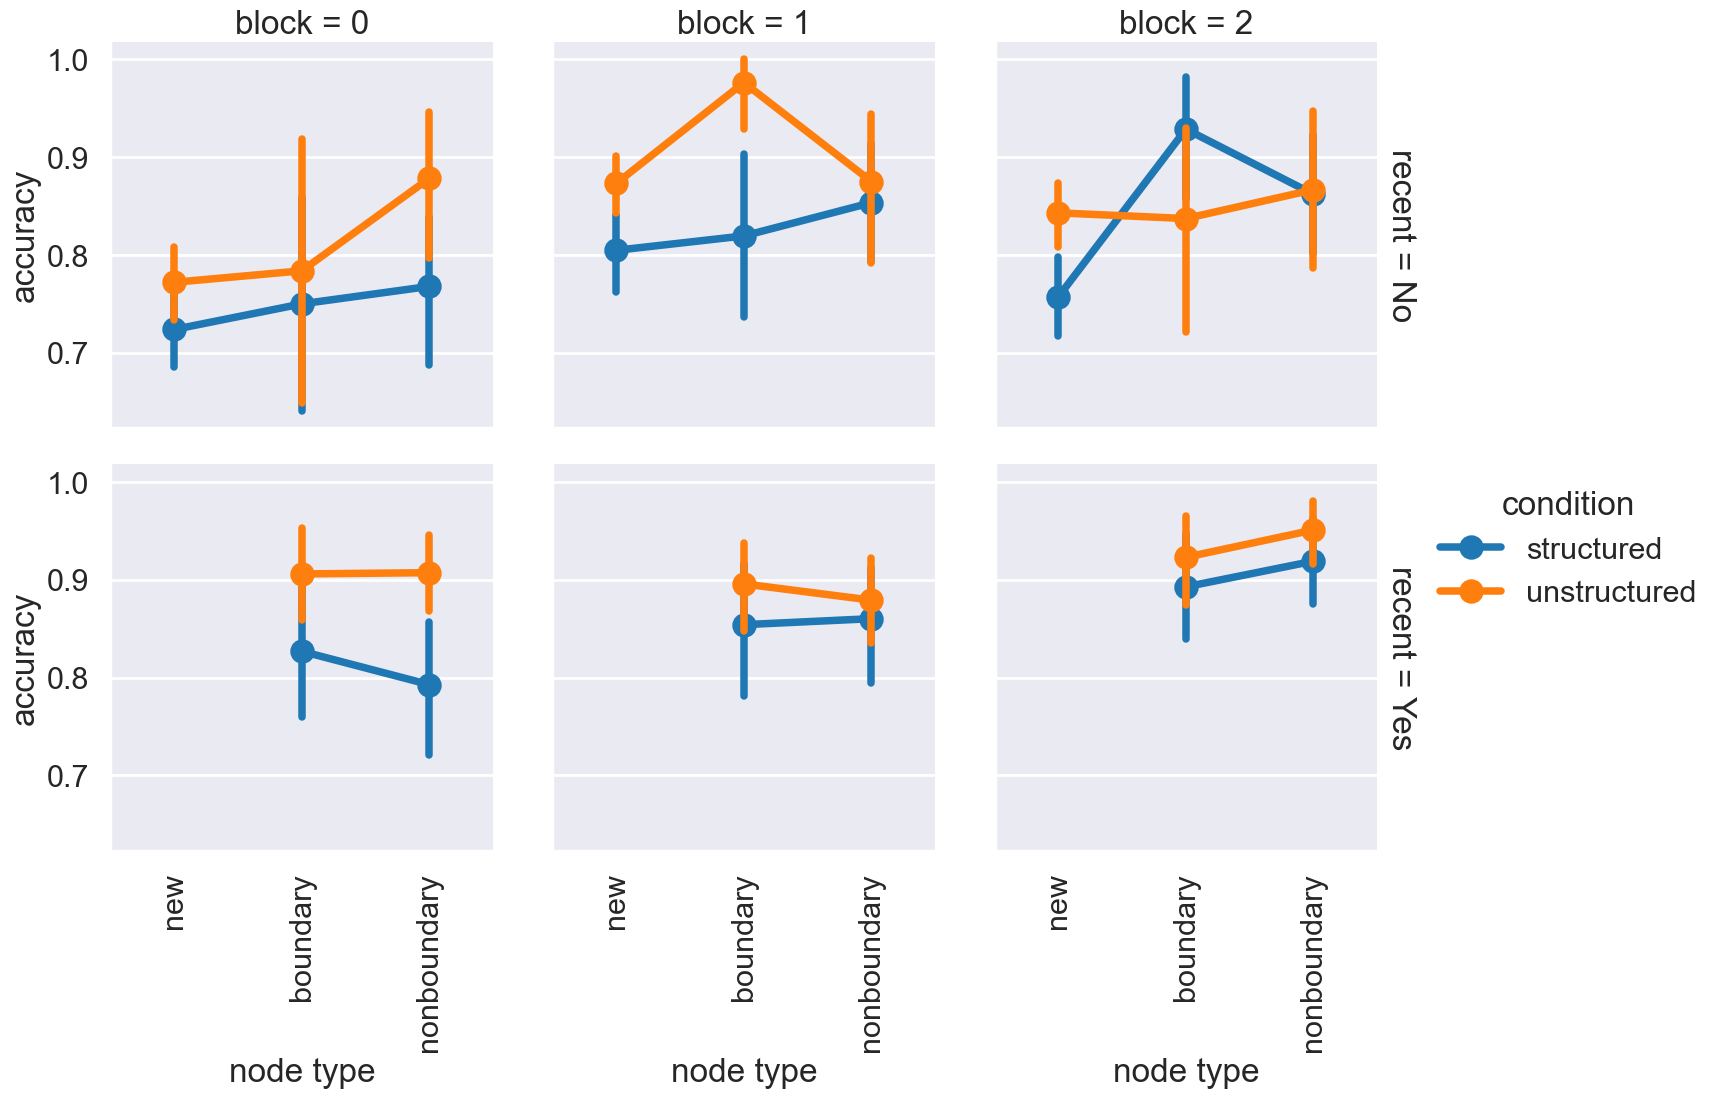

In [ ]:
g = sns.catplot(x = 'node type', y = 'accuracy',  
           data = df_clean_memory, kind = 'point', margin_titles=True, order = ['new', 'boundary', 'nonboundary'], row = 'recent',
                col = 'block', hue = 'condition')
g.set_xticklabels(['new', 'boundary', 'nonboundary'], rotation=90)

In [ ]:
df_clean_exposure['trial_bins'] = (df_clean_exposure['trials']/150).astype(int)

In [ ]:
df_clean_exposure_rt_outlier = df_clean_exposure[np.abs(stat.zscore(df_clean_exposure['rt'], nan_policy='omit')) < 3]


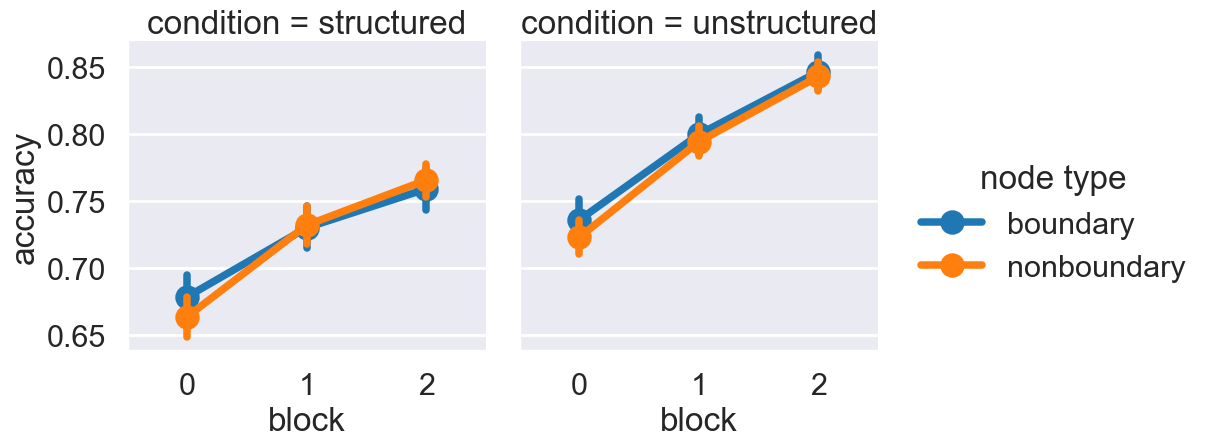

In [ ]:
g = sns.catplot(x = 'block', y = 'accuracy',  col = 'condition',
           data = df_clean_exposure, kind = 'point', margin_titles=True, hue = 'node type')
# g.set_xticklabels(rotation=90)

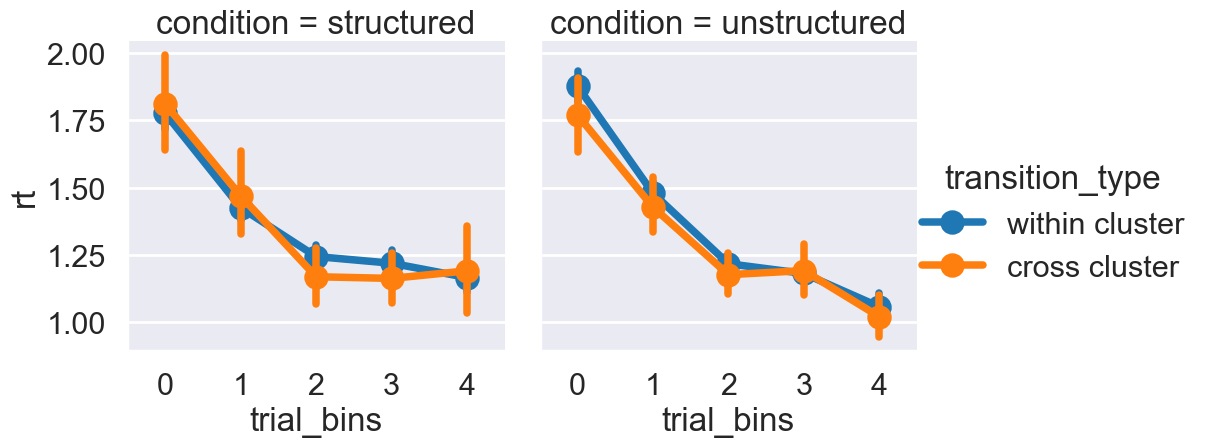

In [ ]:
sns.catplot(x = 'trial_bins', y = 'rt',  col = 'condition', estimator='mean',
           data = df_clean_exposure, hue = 'transition_type', kind = 'point')
# g.set_xticklabels(rotation=90)

In [ ]:
df_clean_exposure['phase'] = 'exposure'
df_clean_memory['phase'] = 'memory'

In [ ]:
concat_df = pd.concat([df_clean_exposure[['rt', 'accuracy', 'condition', 'block', 'node type', 'participant', 'phase']],
df_clean_memory[['rt', 'accuracy', 'condition', 'block', 'node type', 'participant', 'phase']]]).reset_index(drop=True)

# Read the processed data directly

In [ ]:
concat_df = pd.read_csv('exp_recog_concat_df.csv')

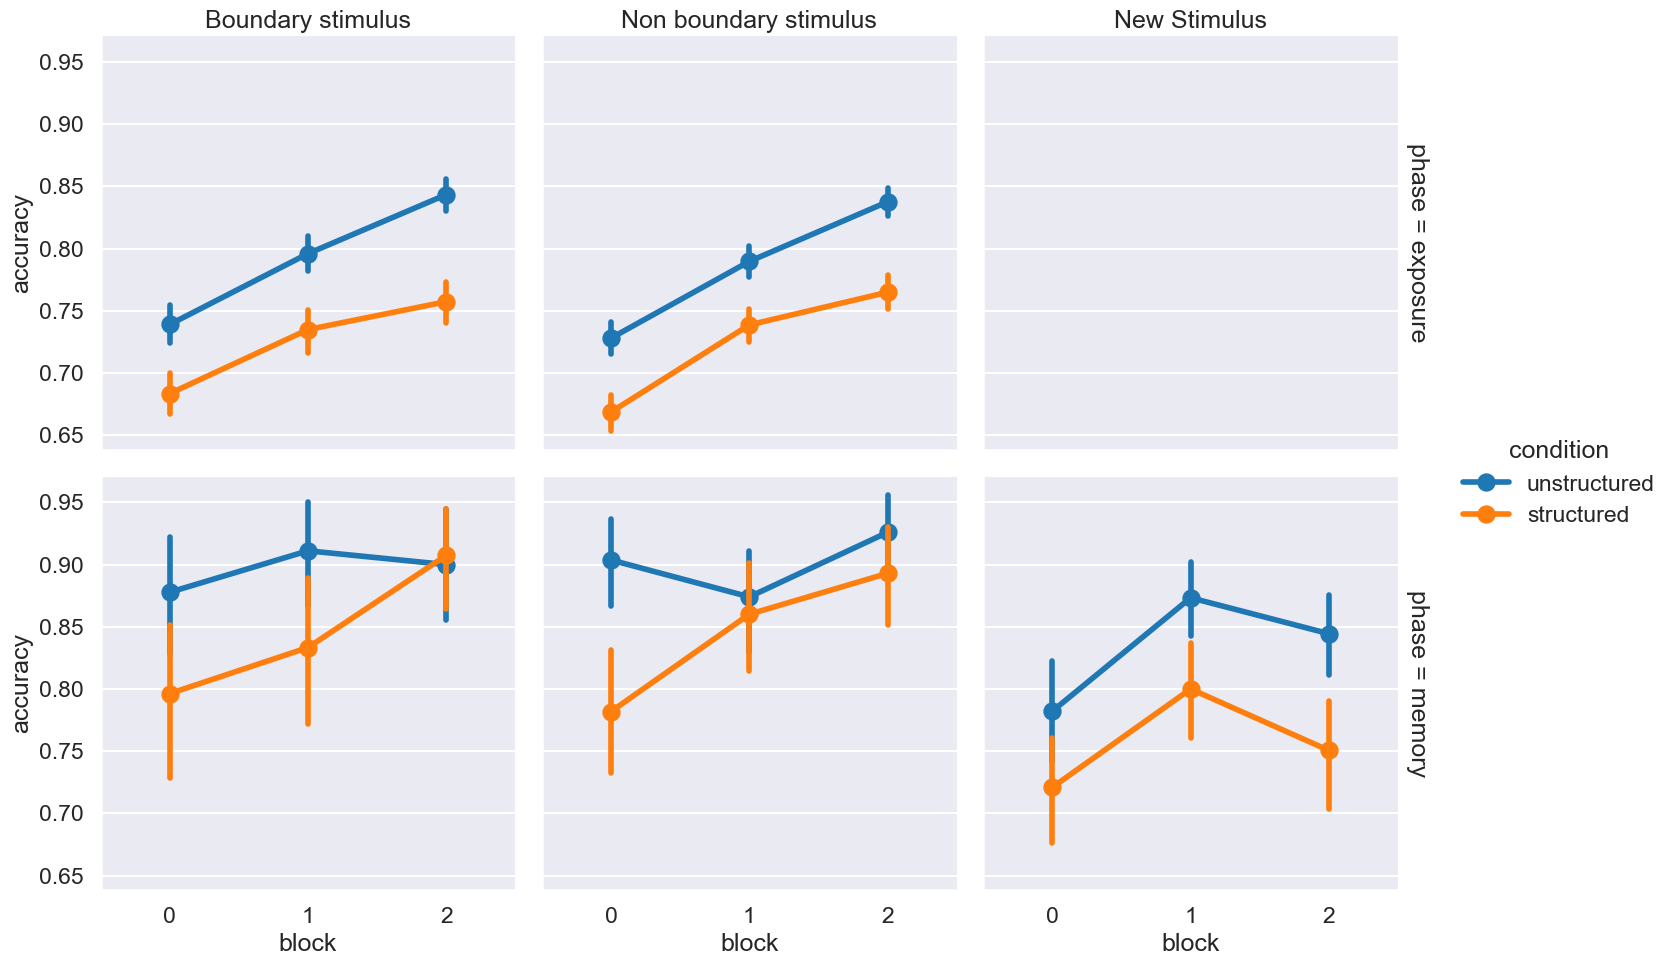

In [ ]:
stim_types = ['Boundary stimulus', 'Non boundary stimulus', 'New Stimulus']

g = sns.catplot(hue = 'condition', y = 'accuracy', col = 'node type', row = 'phase', x = 'block', 
            data = concat_df, kind = 'point', margin_titles=True)
for i, ax in enumerate(g.axes[0]):
    # ax.set_xlabel('Block Number')
    ax.set_title(stim_types[i])
plt.savefig('figures/exposure_recog_accuracy_allphases.png', transparent = True, dpi = 300)

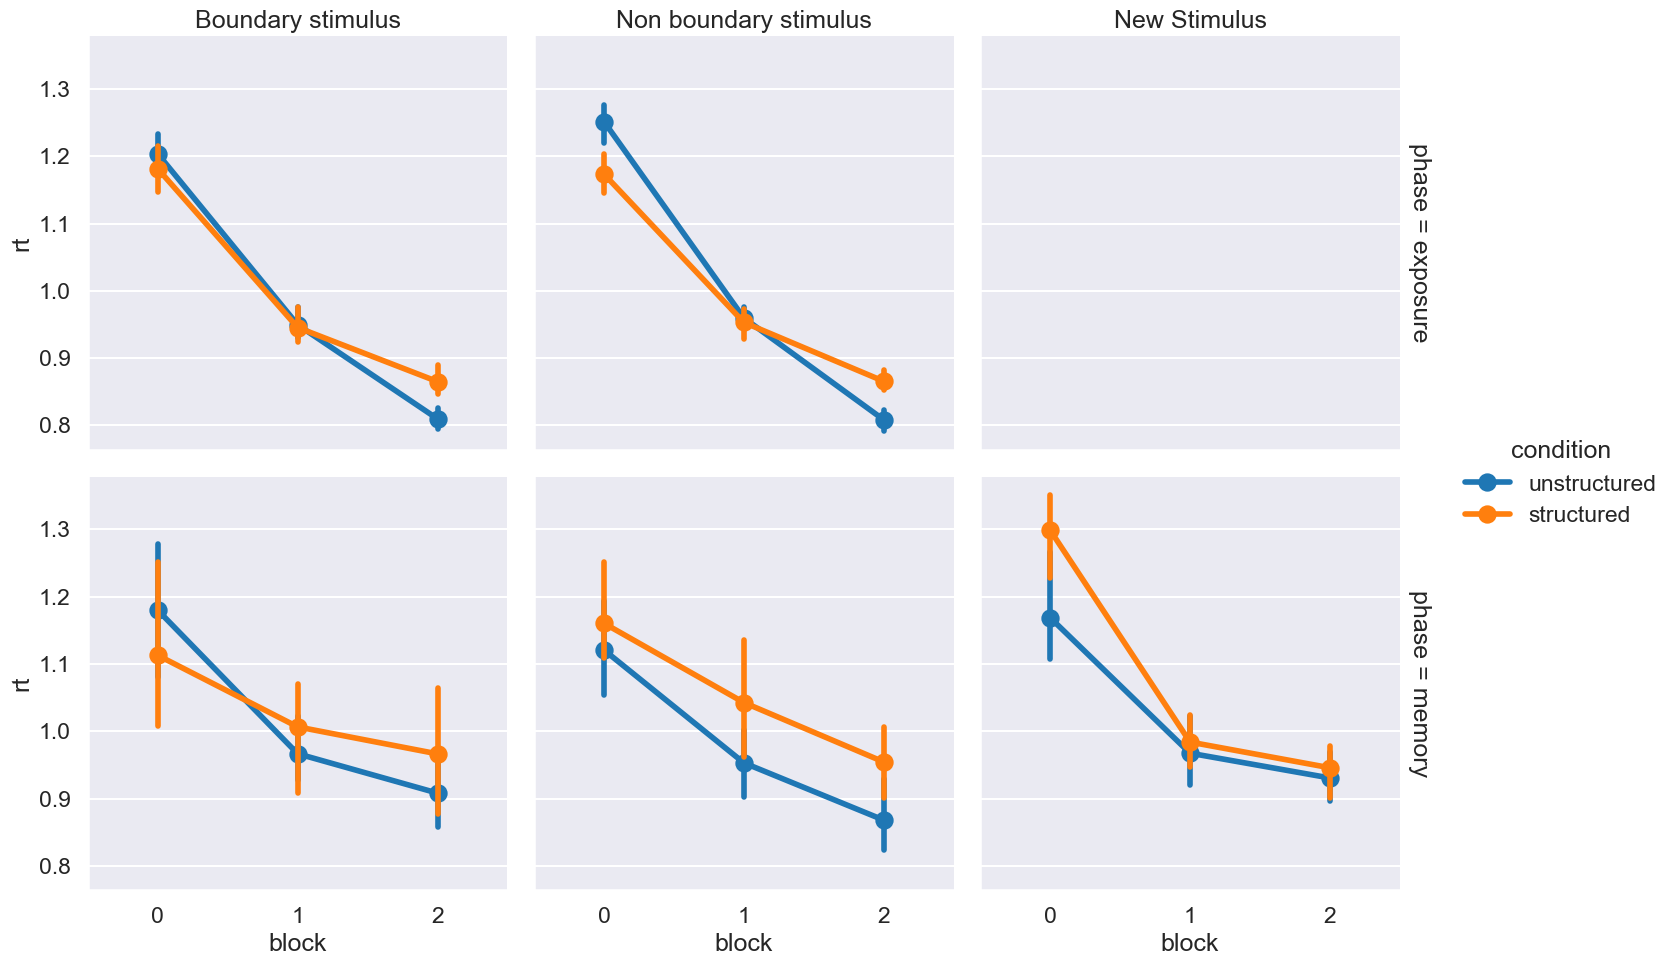

In [ ]:
stim_types = ['Boundary stimulus', 'Non boundary stimulus', 'New Stimulus']

g = sns.catplot(hue = 'condition', y = 'rt', col = 'node type', row = 'phase', x = 'block', 
            data = concat_df, kind = 'point', margin_titles=True, estimator='median')
for i, ax in enumerate(g.axes[0]):
    # ax.set_xlabel('Block Number')
    ax.set_title(stim_types[i])
plt.savefig('figures/exposure_recog_rt_allphases.png', transparent = True, dpi = 300)

# Writing stats to latex tables

In [ ]:
concat_df[['node type', 'block', 'condition', 'phase', 'accuracy', 'rt']].groupby(by = ['phase', 'block', 'node type', 'condition']).describe().iloc()[:, [1, 2, 9, 10]].round(3).to_latex(buf = 'tables/rt-accuracy-stats.txt', float_format="%.3f")
# concat_df[['node type', 'condition', 'phase', 'accuracy', 'rt']].groupby(by = ['phase', 'node type', 'condition']).describe().iloc()[:, [9, 10]].round(3).to_latex(buf = 'tables/rt-stats.txt', float_format="%.3f")

In [ ]:
# df_clean = pd.concat([clean_data(f, 'learning') for f in data_files]).reset_index(drop = True)
# df_clean['reset'] = 'False'
# df_clean.loc[df_clean['trial'].values%(df_clean['walk_length'].values+1) == 0, 'reset'] = 'True'



# df_clean_rt_outlier = df_clean[np.abs(stat.zscore(df_clean['rt'], nan_policy='omit')) < 3]
# df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']

# df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'graph identity', 'condition', 'test no']).mean(numeric_only = True).reset_index()

# # df_clean_rt_outlier['walk_length'] = df_clean_rt_outlier.walk_length.astype('str')
# # df_clean_rt_outlier['num_keypress'] = df_clean_rt_outlier['num_keypress'].astype(str)

# df_clean_participant

In [ ]:
# df_clean_memory['resp_old'] = 1
# df_clean_memory.loc[((df_clean_memory['old or new'] == 'new') & df_clean_memory.accuracy), 'resp_old'] = 0
# df_clean_memory.loc[((df_clean_memory['old or new'] == 'old') & (1 - df_clean_memory.accuracy)), 'resp_old'] = 0


# df_clean_memory['true_old'] = 1
# df_clean_memory.loc[df_clean_memory['node type'] == 'new', 'true_old'] = 0



In [ ]:
df_clean_memory_joined = pd.read_csv('df_clean_memory_joined.csv')
df_clean_memory_joined['true_old'] = 1
df_clean_memory_joined.loc[df_clean_memory_joined['node type'] == 'new', 'true_old'] = 0


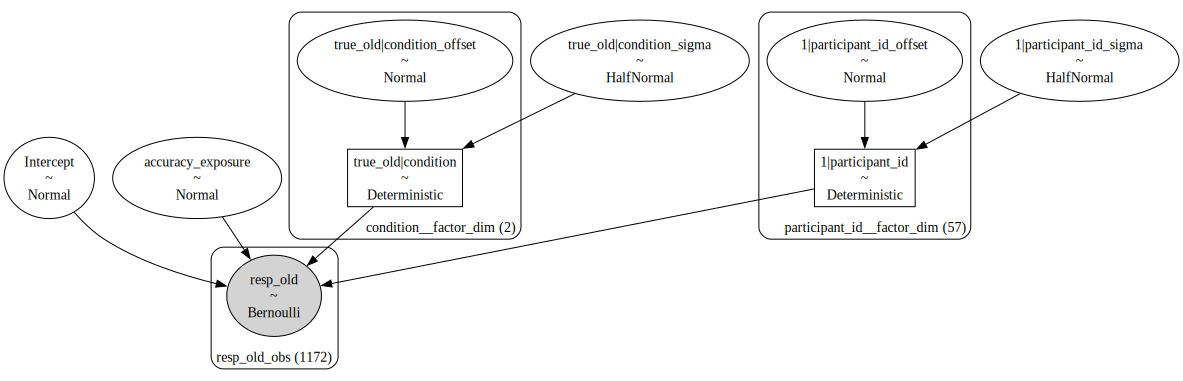

In [ ]:
boundary_bmb_model = bmb.Model('resp_old ~  (0 + true_old|condition) + accuracy_exposure +  (1|participant_id)', family='bernoulli', data = df_clean_memory_joined.loc[((df_clean_memory_joined['node_type'] != 'nonboundary') & ((df_clean_memory_joined['block'] == 2)))].reset_index(drop=True), noncentered=True)
boundary_bmb_model.build()
boundary_bmb_model.graph()

In [ ]:
boundary_samples = boundary_bmb_model.fit(target_accept = 0.9)

Modeling the probability that resp_old==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, accuracy_exposure, true_old|condition_sigma, true_old|condition_offset, 1|participant_id_sigma, 1|participant_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0.5, 1.0, 'd_')

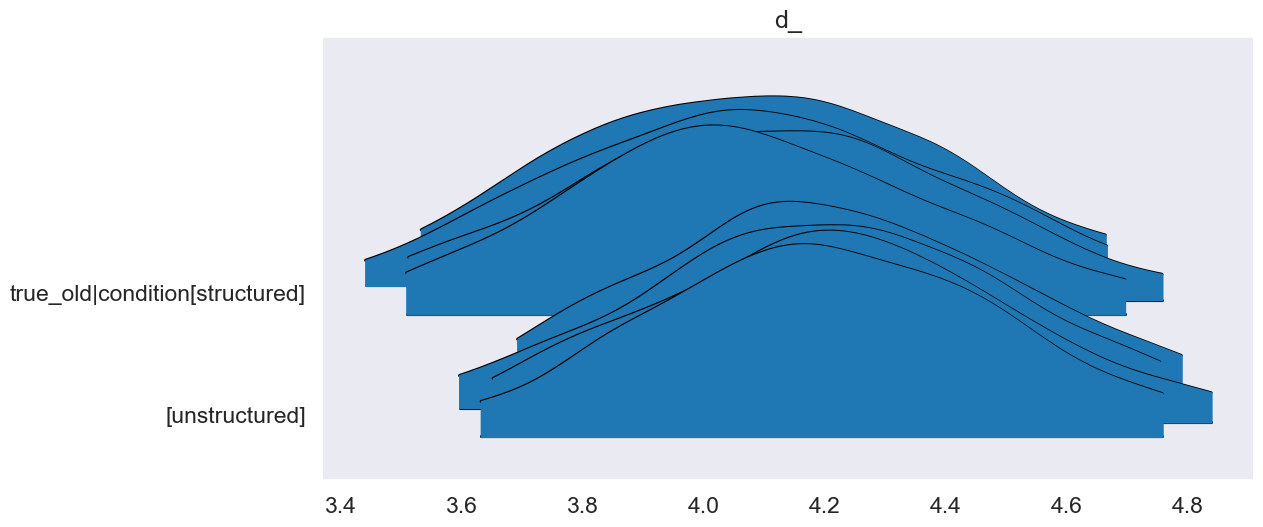

In [ ]:
az.plot_forest(boundary_samples, var_names=["true_old|condition"], kind='ridgeplot')
plt.title('d_')

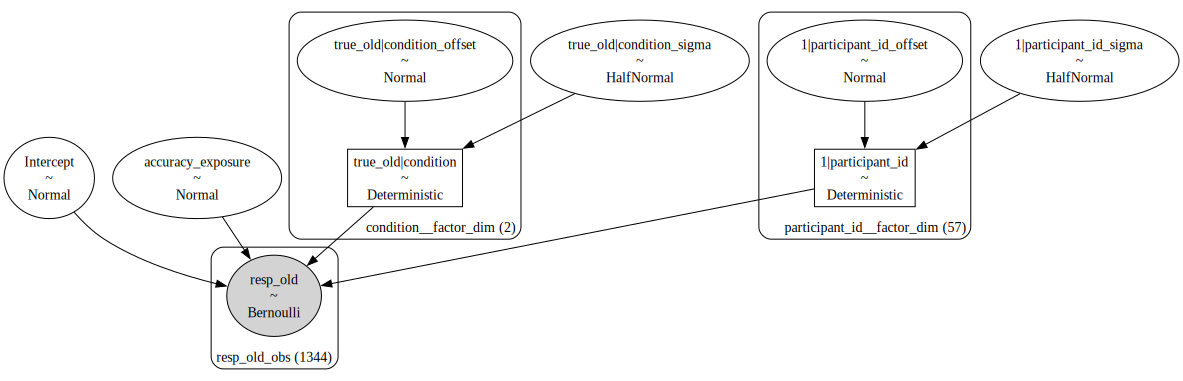

In [ ]:
bmb_model_nonboundary = bmb.Model('resp_old ~  (0 + true_old|condition) + accuracy_exposure +  (1|participant_id)', family='bernoulli', data = df_clean_memory_joined.loc[((df_clean_memory_joined['node_type'] != 'boundary') & ((df_clean_memory_joined['block'] == 2)))].reset_index(drop=True), noncentered=True)
bmb_model_nonboundary.build()
bmb_model_nonboundary.graph(dpi = 300, name = 'figures/sdt_model_graph.png')

In [ ]:
nonboundary_samples = bmb_model_nonboundary.fit()

Modeling the probability that resp_old==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, accuracy_exposure, true_old|condition_sigma, true_old|condition_offset, 1|participant_id_sigma, 1|participant_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 136 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
az.summary(boundary_samples, var_names=["accuracy_exposure", "true_old"], filter_vars="like").iloc[:, :4].to_latex('tables/boundary_sdt_stats.txt', float_format="%.3f")
az.summary(nonboundary_samples, var_names=["accuracy_exposure", "true_old"], filter_vars="like").iloc[:, :4].to_latex('tables/nonboundary_sdt_stats.txt', float_format="%.3f")



In [ ]:
boundary_bmb_model.predict(boundary_samples, kind='pps')
bmb_model_nonboundary.predict(nonboundary_samples, kind='pps')


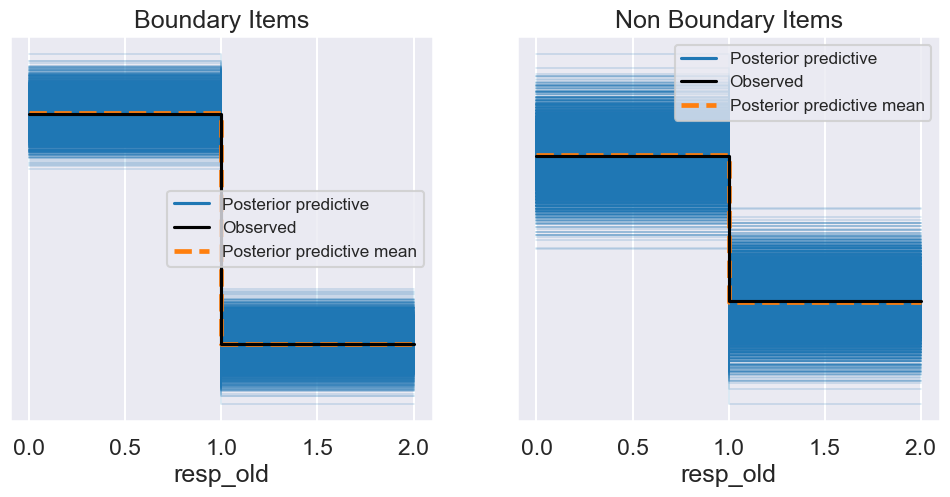

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
az.plot_ppc(boundary_samples, ax=ax[0])
az.plot_ppc(nonboundary_samples, ax=ax[1])
ax[0].set_title('Boundary Items')
ax[1].set_title('Non Boundary Items')
plt.savefig('figures/ppc_sdt_model.png', dpi = 300, transparent=True)

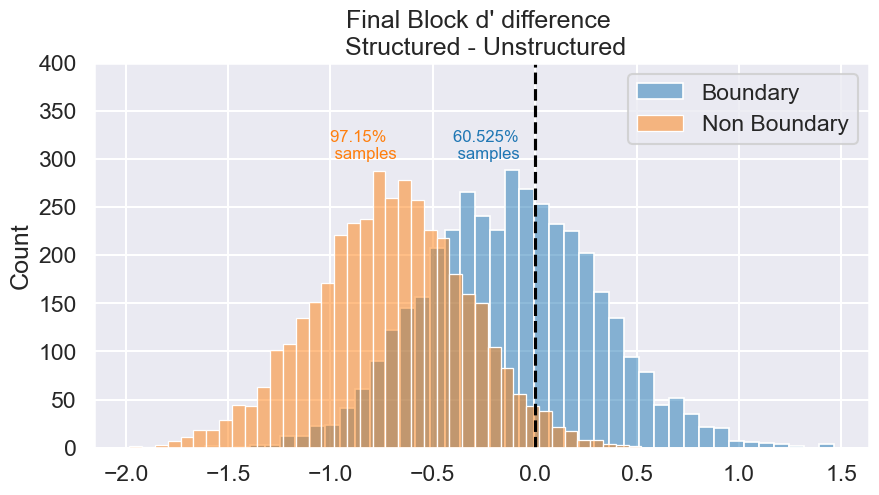

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
extracted = az.extract(boundary_samples, var_names='true_old|condition')
le0 = np.mean(extracted.sel({"condition__factor_dim" : 'structured'}) - extracted.sel({"condition__factor_dim" : 'unstructured'}) < 0).values*100
ax.text(x = -.4, y = 300, s = f"{le0}% \n samples", color = 'C0', size = 12)
sns.histplot(extracted.sel({"condition__factor_dim" : 'structured'}) - extracted.sel({"condition__factor_dim" : 'unstructured'}), alpha = 0.5, ax = ax, label = 'Boundary')
extracted = az.extract(nonboundary_samples, var_names='true_old|condition')

sns.histplot(extracted.sel({"condition__factor_dim" : 'structured'}) - extracted.sel({"condition__factor_dim" : 'unstructured'}), alpha = 0.5, ax = ax, label = 'Non Boundary')
ax.legend()
ax.axvline(x = 0, ls = '--', color = 'black')
ax.set_title("Final Block d' difference \n Structured - Unstructured")
le0 = np.mean(extracted.sel({"condition__factor_dim" : 'structured'}) - extracted.sel({"condition__factor_dim" : 'unstructured'}) < 0).values*100
ax.text(x = -1, y = 300, s = f"{le0}% \n samples", color = 'C1', size = 12)
ax.set_ylim((0, 400))
plt.savefig('figures/sdt_d_results.png', dpi = 300, transparent = True)


array([[3.63258834, 3.84505944, 3.63100696, ..., 3.78658343, 3.43557527,
        4.37567551],
       [3.901399  , 4.6459668 , 4.39820518, ..., 4.71701078, 4.90000415,
        4.51545052]])

<Axes: xlabel='resp_old'>

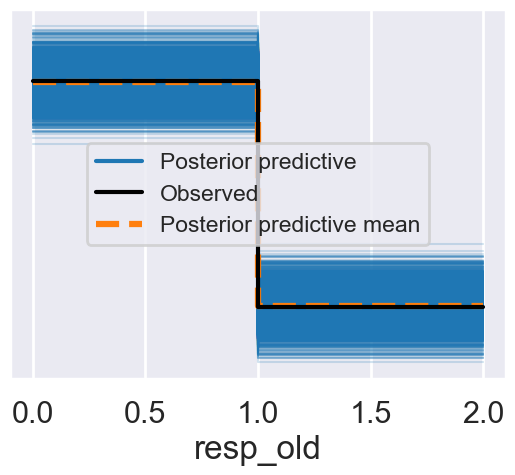

In [ ]:
bmb_model_boundary.predict(boundary_samples, kind = 'pps')
az.plot_ppc(boundary_samples)

In [187]:
print(boundary_bmb_model)

       Formula: resp_old ~  (0 + true_old|condition) + accuracy_exposure +  (1|participant_id)
        Family: bernoulli
          Link: p = logit
  Observations: 1172
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 11.5003)
            accuracy_exposure ~ Normal(mu: 0.0, sigma: 13.8795)
        
        Group-level effects
            true_old|condition ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 5.5333))
            1|participant_id ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 11.5003))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


In [185]:
pm.mod

<module 'pymc.model_graph' from 'c:\\Users\\tejas\\Anaconda3\\envs\\eb_music\\Lib\\site-packages\\pymc\\model_graph.py'>

<Axes: xlabel='resp_old'>

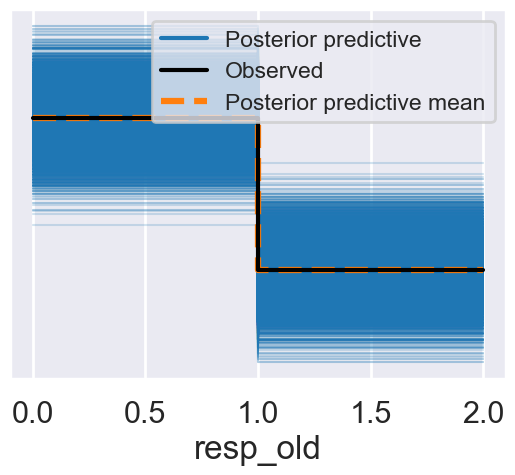

In [ ]:
bmb_model_nonboundary.predict(nonboundary_samples, kind = 'pps')
az.plot_ppc(nonboundary_samples)


In [ ]:
az.summary(boundary_samples)

NameError: name 'boundary_samples' is not defined

array([0.83541631])

In [ ]:
hssm.set_floatX("float32")


Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [ ]:
# df_clean_memory

In [ ]:
# df_clean_memory_joined.head(10)

<Axes: xlabel='rt', ylabel='Count'>

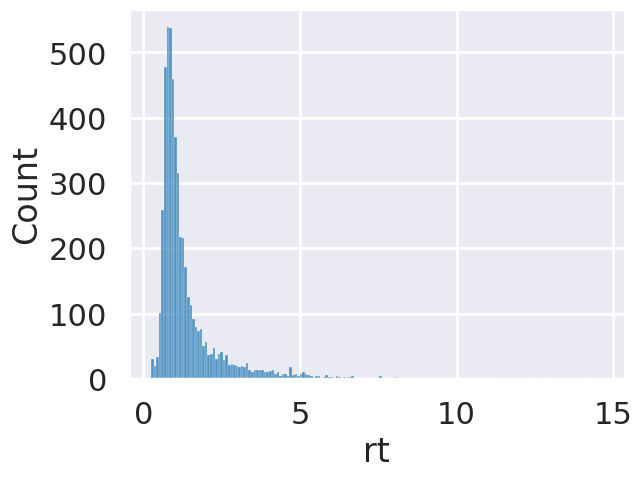

In [ ]:
sns.histplot(df_clean_memory_joined.rt)

In [ ]:
ddm_model = hssm.HSSM(hierarchical=False, prior_settings='safe', t = 0.25, loglik_kind="approx_differentiable", 
                           data = df_clean_memory_joined[['participant_id', 'response', 'rt', "node_type", "condition", "block", "accuracy_exposure"]],  
                      include=[
                                {
                                    "name": "v",
                                    "formula": "v ~ 0 + C(node_type):C(condition):C(block) + accuracy_exposure",
                                    "link": "identity"
                                    # "prior": {"name": "Normal", "mu": 0, "sigma": 0.01},
                                },
                          {
                              "name": "z",
                              "formula": "z ~ 0 + C(block)"
                          },

                          {
                              "name": "a",
                              "formula": "a ~ 0 + C(condition):C(block)"
                          },

                              ],
                     )


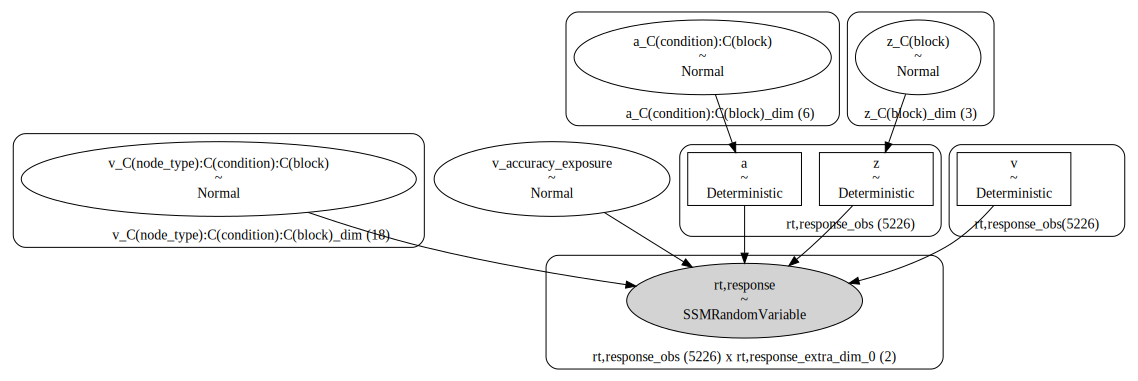

In [ ]:
ddm_model.graph()

In [ ]:
ddm_model_samples = az.from_netcdf('hssm_results/t_range/v~hrl_nodetype:cond:block+accexp_z~block_a~cond:block_trange_fixedt.nc')
ddm_model._inference_obj = ddm_model_samples

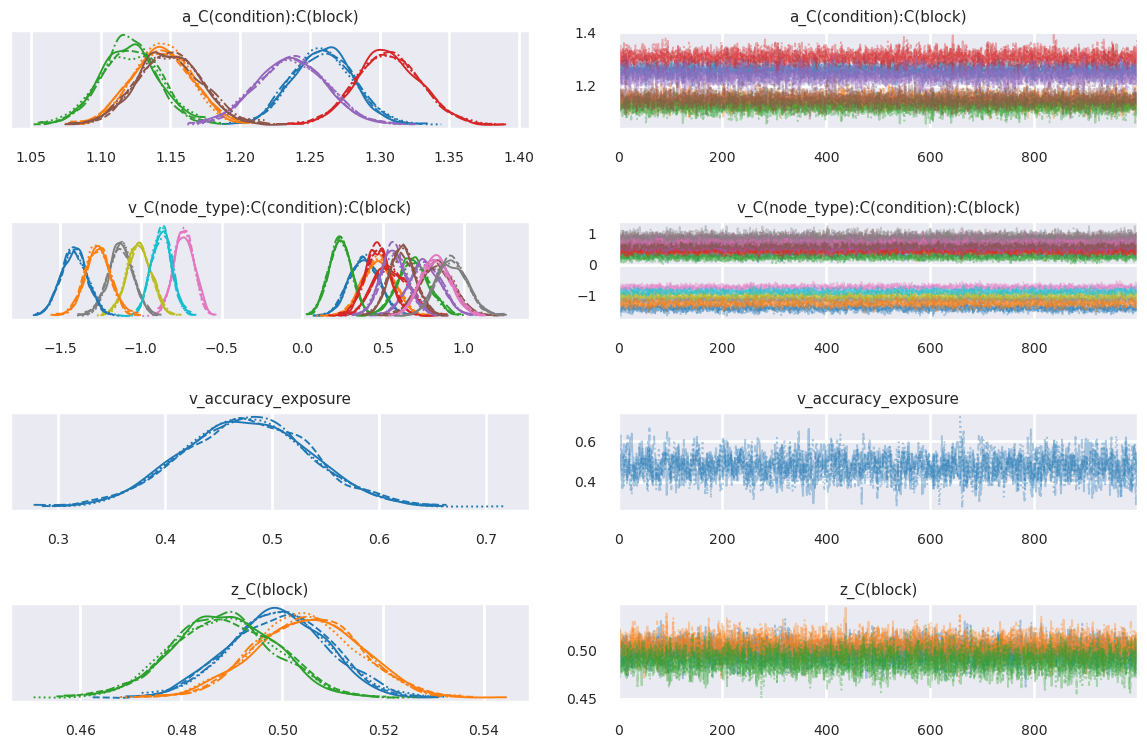

In [ ]:
ddm_model.plot_trace()

array([[<Axes: ylabel='v_accuracy_exposure'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='v_C(node_type):C(condition):C(block)\nboundary, structured, 0'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='v_C(node_type):C(condition):C(block)\nboundary, structured, 1'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='v_C(node_type):C(condition):C(block)\nboundary, structured, 2'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='v_C(node_type):C(condition):C(block)\nboundary, unstructured, 0'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='v_C(node_type):C(condition):C(block)\nboundary, unstructured, 1'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: 

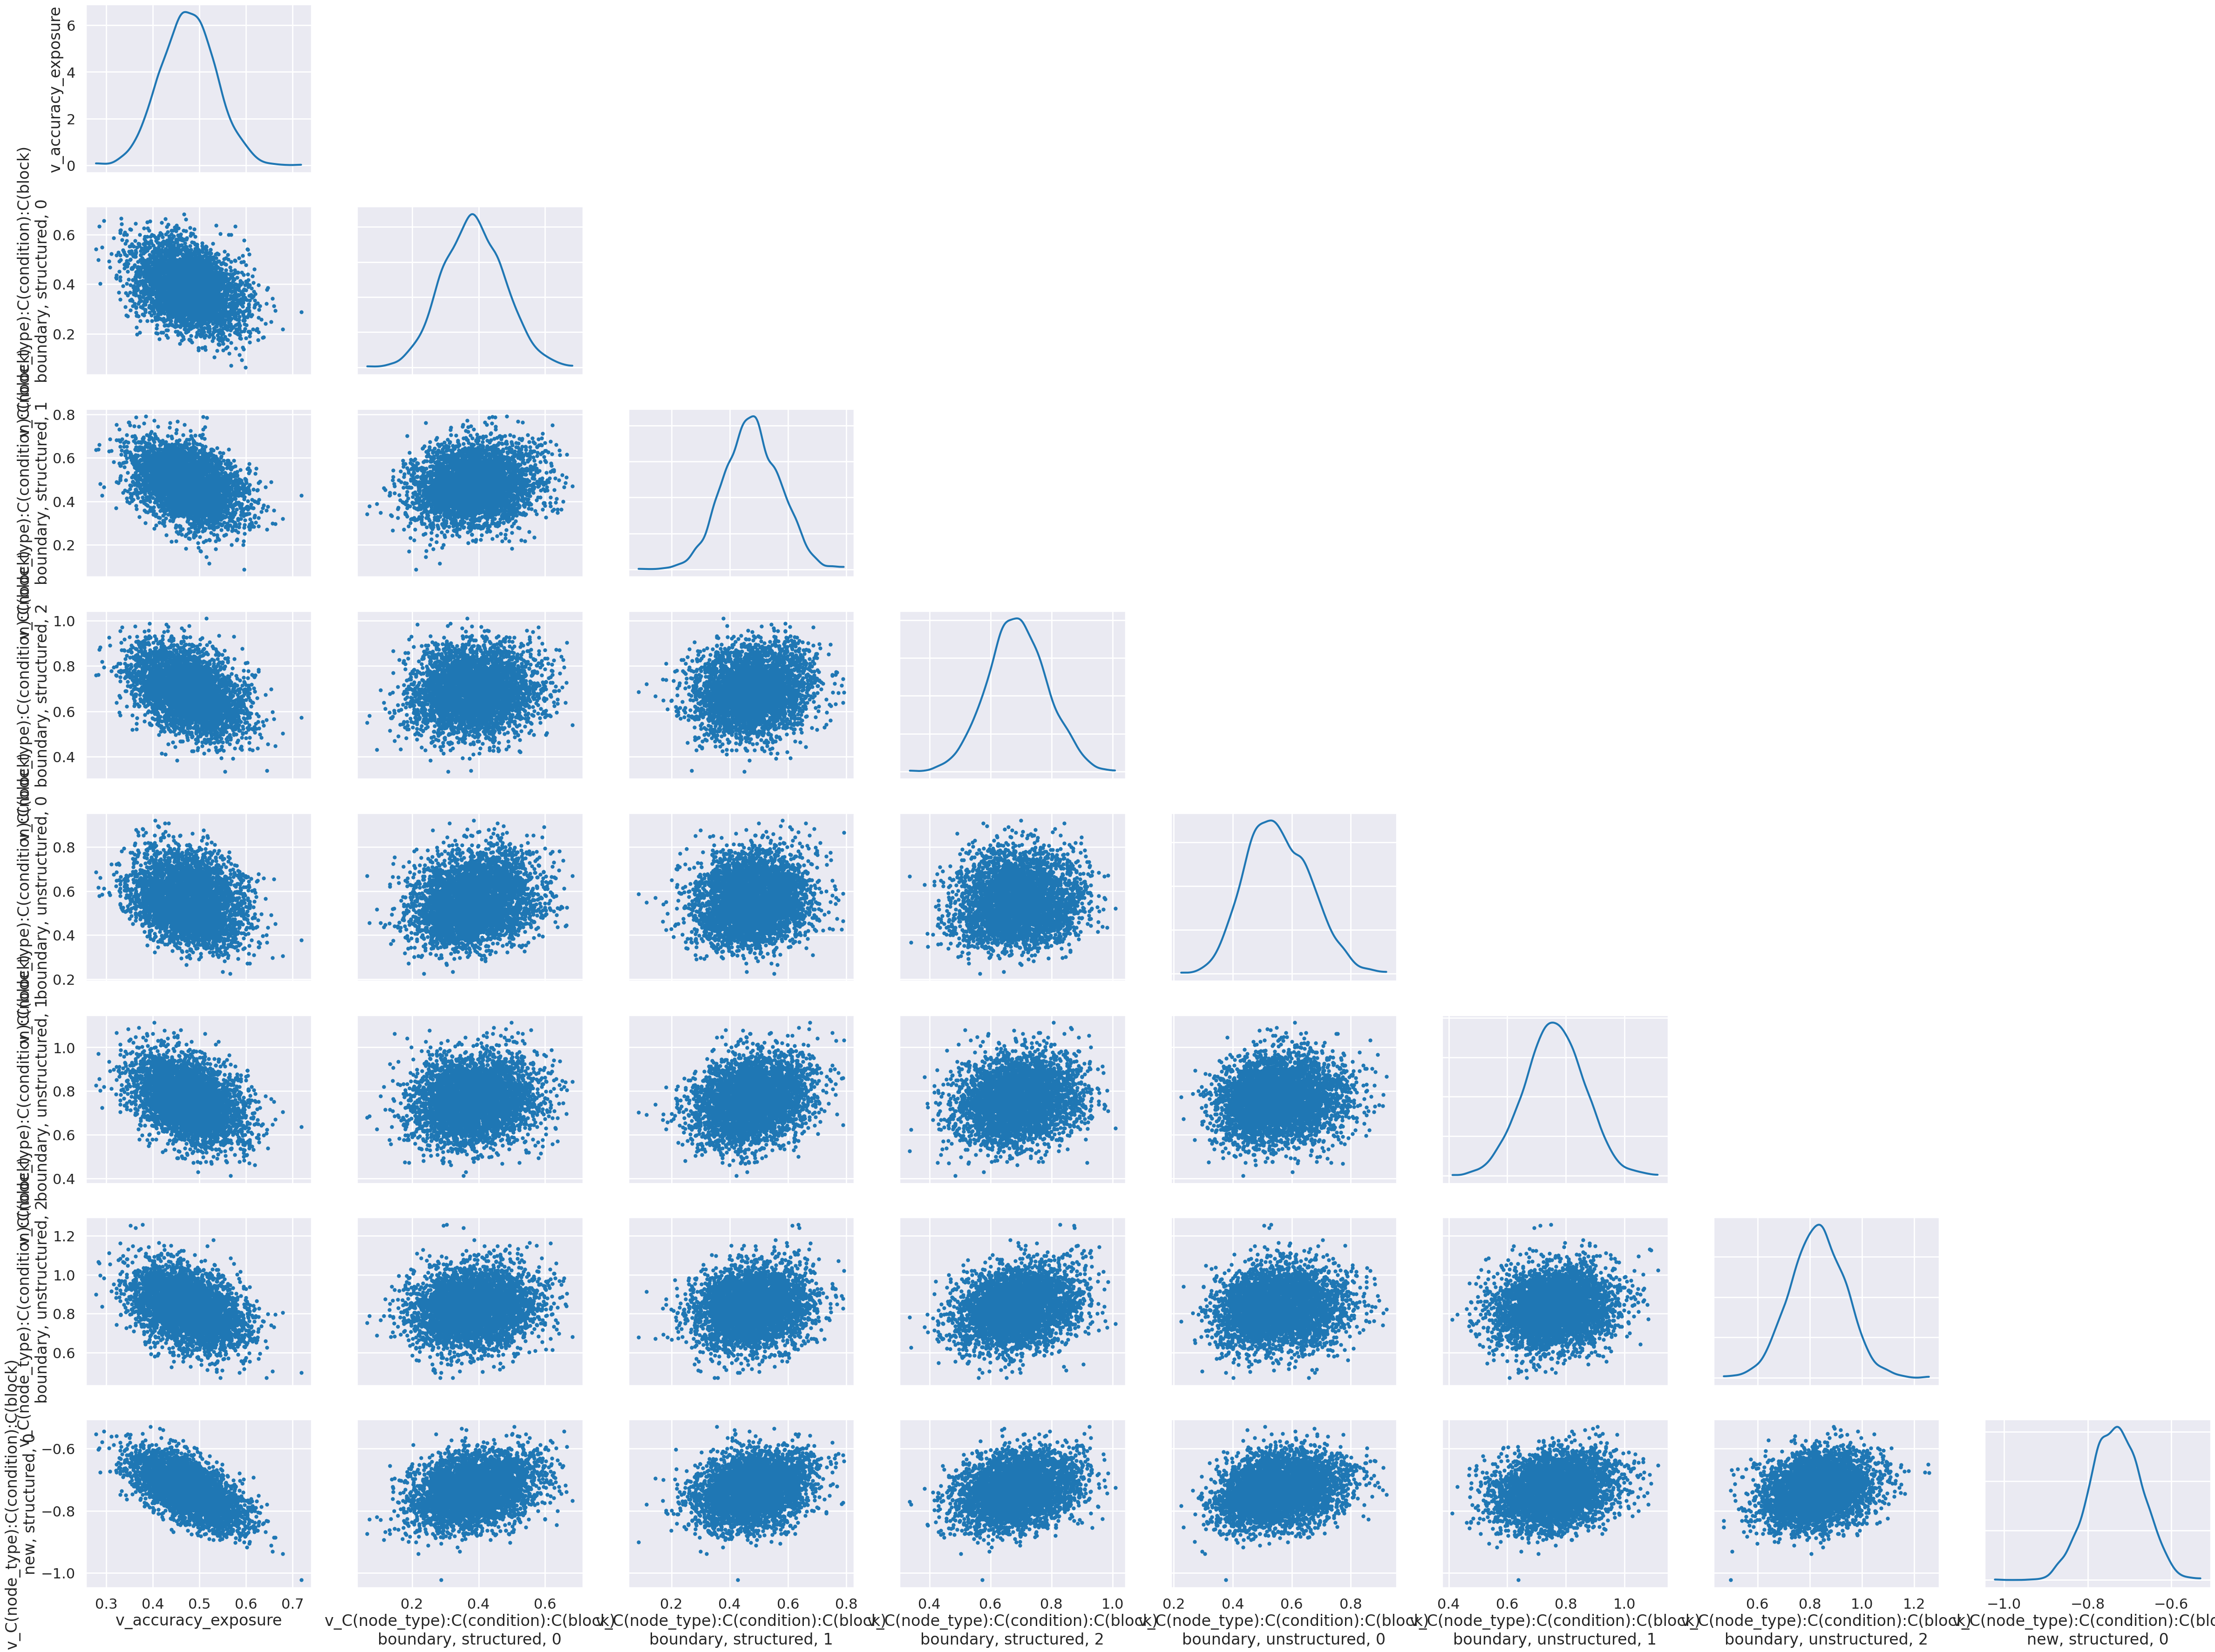

In [ ]:
az.plot_pair(ddm_model_samples, var_names=['v_accuracy_exposure', 'v_C(node_type):C(condition):C(block)'], marginals=True)

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


<Axes: title={'center': 'Posterior Predictive Distribution'}, xlabel='Response Time', ylabel='Density'>

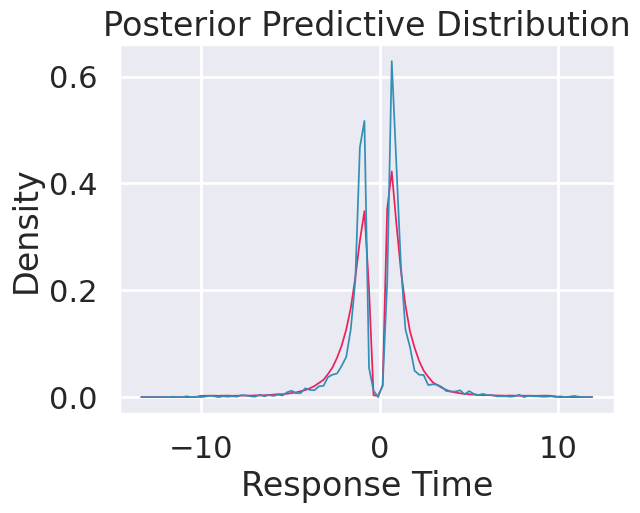

In [ ]:
hssm.plotting.plot_posterior_predictive(ddm_model)

In [ ]:
az.summary(ddm_model._inference_obj, var_names='cond', filter_vars='like')#.summary()

mean     sd  hdi_3%  \
a_C(condition):C(block)[structured, 0]              1.259  0.022   1.220   
a_C(condition):C(block)[structured, 1]              1.144  0.021   1.104   
a_C(condition):C(block)[structured, 2]              1.121  0.021   1.081   
a_C(condition):C(block)[unstructured, 0]            1.306  0.023   1.263   
a_C(condition):C(block)[unstructured, 1]            1.237  0.025   1.193   
a_C(condition):C(block)[unstructured, 2]            1.149  0.023   1.107   
v_C(node_type):C(condition):C(block)[boundary, ...  0.385  0.092   0.202   
v_C(node_type):C(condition):C(block)[boundary, ...  0.476  0.096   0.294   
v_C(node_type):C(condition):C(block)[boundary, ...  0.688  0.097   0.506   
v_C(node_type):C(condition):C(block)[boundary, ...  0.554  0.108   0.357   
v_C(node_type):C(condition):C(block)[boundary, ...  0.761  0.101   0.565   
v_C(node_type):C(condition):C(block)[boundary, ...  0.830  0.106   0.637   
v_C(node_type):C(condition):C(block)[new, struc... -0.733  0.062  -0.848   
v_C(node_type):C(condition):C(block)[new, struc... -1.124  0.077  -1.267   
v_C(node_type):C(condition):C(block)[new, struc... -1.011  0.075  -1.159   
v_C(node_type):C(condition):C(block)[new, unstr... -0.872  0.062  -0.986   
v_C(node_type):C(condition):C(block)[new, unstr... -1.414  0.081  -1.560   
v_C(node_type):C(condition):C(block)[new, unstr... -1.267  0.079  -1.408   
v_C(node_type):C(condition):C(block)[nonboundar...  0.236  0.069   0.102   
v_C(node_type):C(condition):C(block)[nonboundar...  0.468  0.081   0.326   
v_C(node_type):C(condition):C(block)[nonboundar...  0.570  0.084   0.411   
v_C(node_type):C(condition):C(block)[nonboundar...  0.619  0.079   0.471   
v_C(node_type):C(condition):C(block)[nonboundar...  0.830  0.092   0.663   
v_C(node_type):C(condition):C(block)[nonboundar...  0.927  0.097   0.749   

                                                    hdi_97%  mcse_mean  \
a_C(condition):C(block)[structured, 0]                1.300      0.000   
a_C(condition):C(block)[structured, 1]                1.183      0.000   
a_C(condition):C(block)[structured, 2]                1.159      0.000   
a_C(condition):C(block)[unstructured, 0]              1.349      0.000   
a_C(condition):C(block)[unstructured, 1]              1.284      0.000   
a_C(condition):C(block)[unstructured, 2]              1.191      0.000   
v_C(node_type):C(condition):C(block)[boundary, ...    0.546      0.002   
v_C(node_type):C(condition):C(block)[boundary, ...    0.653      0.002   
v_C(node_type):C(condition):C(block)[boundary, ...    0.873      0.002   
v_C(node_type):C(condition):C(block)[boundary, ...    0.753      0.002   
v_C(node_type):C(condition):C(block)[boundary, ...    0.944      0.002   
v_C(node_type):C(condition):C(block)[boundary, ...    1.029      0.002   
v_C(node_type):C(condition):C(block)[new, struc...   -0.618      0.001   
v_C(node_type):C(condition):C(block)[new, struc...   -0.980      0.002   
v_C(node_type):C(condition):C(block)[new, struc...   -0.879      0.002   
v_C(node_type):C(condition):C(block)[new, unstr...   -0.754      0.001   
v_C(node_type):C(condition):C(block)[new, unstr...   -1.259      0.002   
v_C(node_type):C(condition):C(block)[new, unstr...   -1.112      0.002   
v_C(node_type):C(condition):C(block)[nonboundar...    0.362      0.001   
v_C(node_type):C(condition):C(block)[nonboundar...    0.631      0.002   
v_C(node_type):C(condition):C(block)[nonboundar...    0.730      0.002   
v_C(node_type):C(condition):C(block)[nonboundar...    0.768      0.001   
v_C(node_type):C(condition):C(block)[nonboundar...    1.005      0.002   
v_C(node_type):C(condition):C(block)[nonboundar...    1.114      0.002   

                                                    mcse_sd  ess_bulk  \
a_C(condition):C(block)[structured, 0]                0.000    7492.0   
a_C(condition):C(block)[structured, 1]                0.000    5885.0   
a_C(condition):C(block)[structured, 2]                0.000    5927.0   
a_C(condi

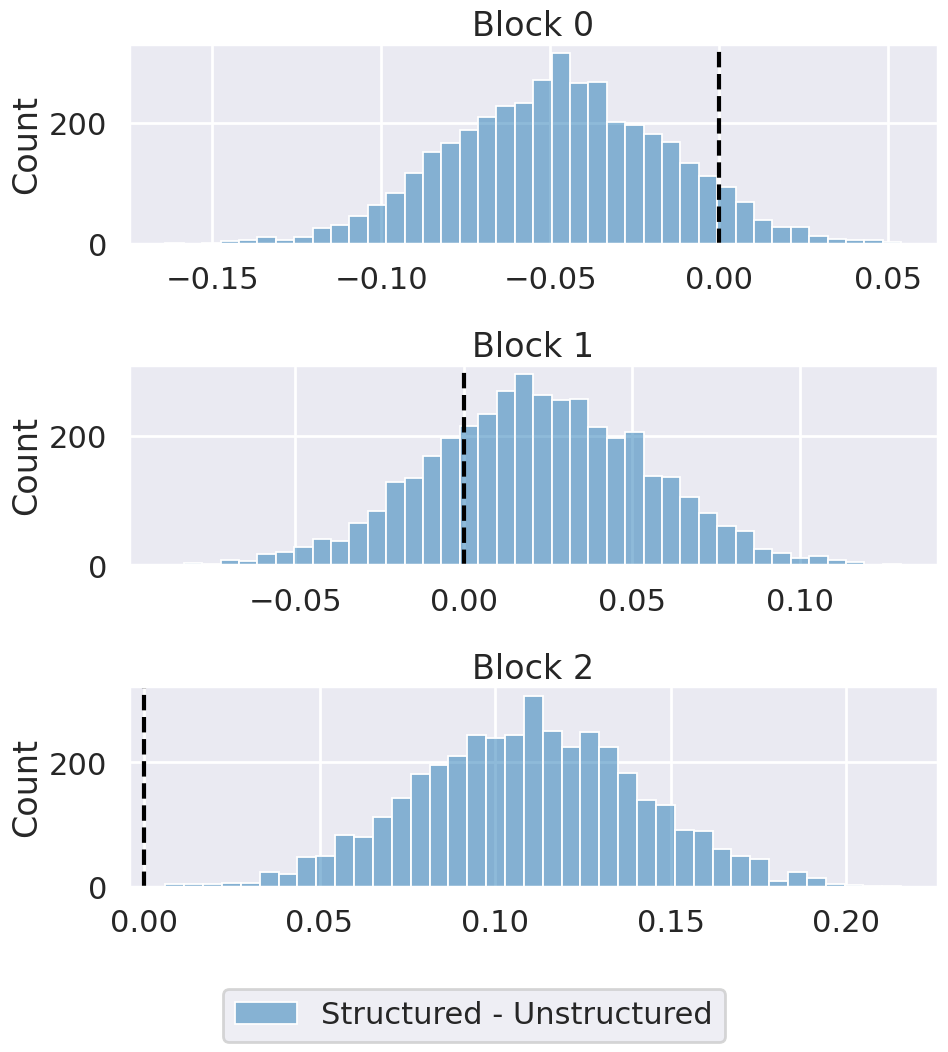

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize = (10, 10))
extracted = az.extract(ddm_model_samples, var_names='a_C(condition):C(block)')
# sns.histplot(extracted[0], alpha = 0.5, ax = ax, label = 'New Unstructured - Boundary Structured')
for i in range(3):
    # sns.histplot(extracted[i] - extracted[i + 3], alpha = 0.5, ax = ax[i], label = 'Boundary Structured - UnStructured')
    # sns.histplot(extracted[i + 12] - extracted[i + 15], alpha = 0.5, ax = ax[i], label = 'NonBoundary Structured - UnStructured')
    # sns.histplot(extracted[i + 6] - extracted[i + 9], alpha = 0.5, ax = ax[i], label = 'New Structured - Unstructured')
    
    # sns.histplot(extracted[i] - extracted[i + 12], alpha = 0.5, ax = ax[i], label = 'Boundary - Non Boundary Structured')
    # sns.histplot(extracted[i + 3] - extracted[i + 15], alpha = 0.5, ax = ax[i], label = 'Boundary - Non Boundary UnStructured')
    # sns.histplot(extracted[i + 6] - extracted[i + 9], alpha = 0.5, ax = ax[i], label = 'New Structured - Unstructured')
    sns.histplot(extracted[0] - extracted[i + 3], alpha = 0.5, ax = ax[i], label = 'Structured - Unstructured')

    ax[i].axvline(x = 0, ls = '--', color = 'black')
    ax[i].set_title(f'Block {i}')



# sns.histplot(extracted[1], alpha = 0.5, ax = ax, label = 'New')
# extracted = az.extract(ddm_model_samples, var_names='v_C(node_type):C(condition)')
# sns.histplot(extracted[0], alpha = 0.5, ax = ax, label = 'New Unstructured - Boundary Structured')
# sns.histplot(extracted[1], alpha = 0.5, ax = ax, label = 'Boundary Structured - Nonboundary Unstructured')


# extracted = az.extract(nonboundary_samples, var_names='true_old|condition')
# sns.histplot(extracted[0] - extracted[1], alpha = 0.5, ax = ax, label = 'Non Boundary')
# for i in range(3):
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, 0))
fig.tight_layout()

# ax.set_title('Structured - Unstructured d_')


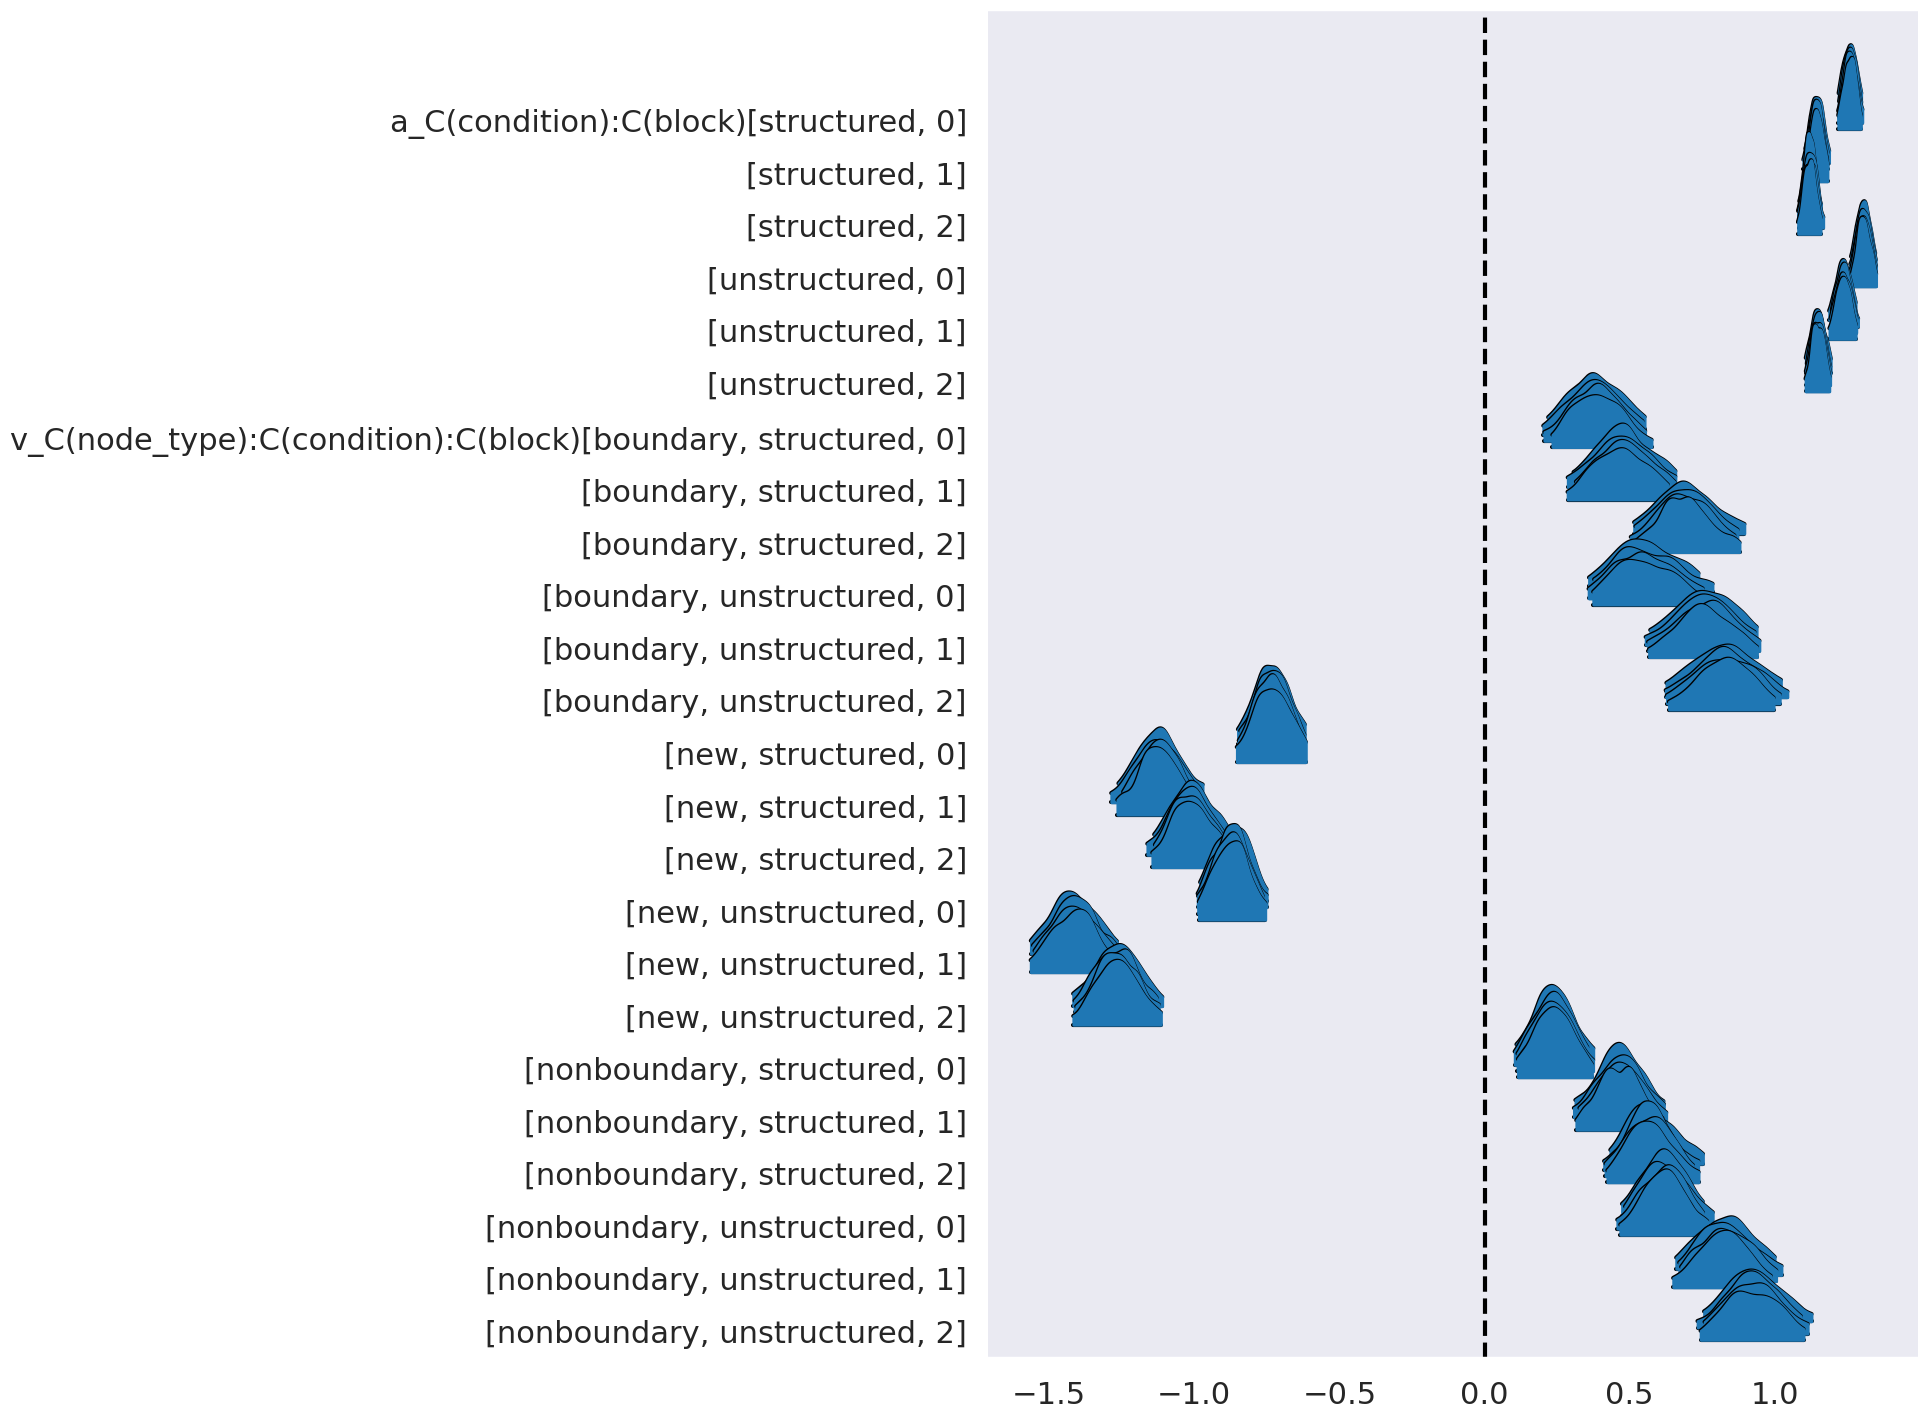

In [ ]:
g = az.plot_forest(ddm_model_samples, var_names="cond", filter_vars = "like", kind = 'ridgeplot')
g[0].axvline(0, ls = '--', color = 'black')

In [ ]:
# model_samples['z~accexp']

In [ ]:
# with DMM_pymc:
#     samples = pm.sample()

In [ ]:
model_samples = {'a/z~acc_exp': az.from_netcdf('hssm_results/t_range/v~hrl_nodetype:cond:block+accexp_z~accexp_a~accexp_trange_fixedt.nc'),
                'a/z~block/cond:block': az.from_netcdf('hssm_results/t_range/v~hrl_nodetype:cond:block+accexp_z~block_a~cond:block_trange_fixedt.nc'),
                 'z~accexp': az.from_netcdf('hssm_results/t_range/v~hrl_nodetype:cond:block_z~accexp_trange_fixedt.nc')
                }


In [ ]:
# hssm.plotting.plot_posterior_predictive(DMM_pymc, samples)

In [ ]:
samples = az.from_netcdf('hssm_results/v~hrl_nodetype_cond_block+accexp_z~block_a~cond_block_trange_fixedt.nc')
#Write the summary to latex table
az.summary(samples, var_names=['v_C', 'a_C', 'z_C'], filter_vars='like').to_latex('tables/ddm_parameter_stats.txt', float_format = "%0.3f")
extracted = az.extract(samples, var_names='v_C(node_type):C(condition):C(block)', filter_vars='like')


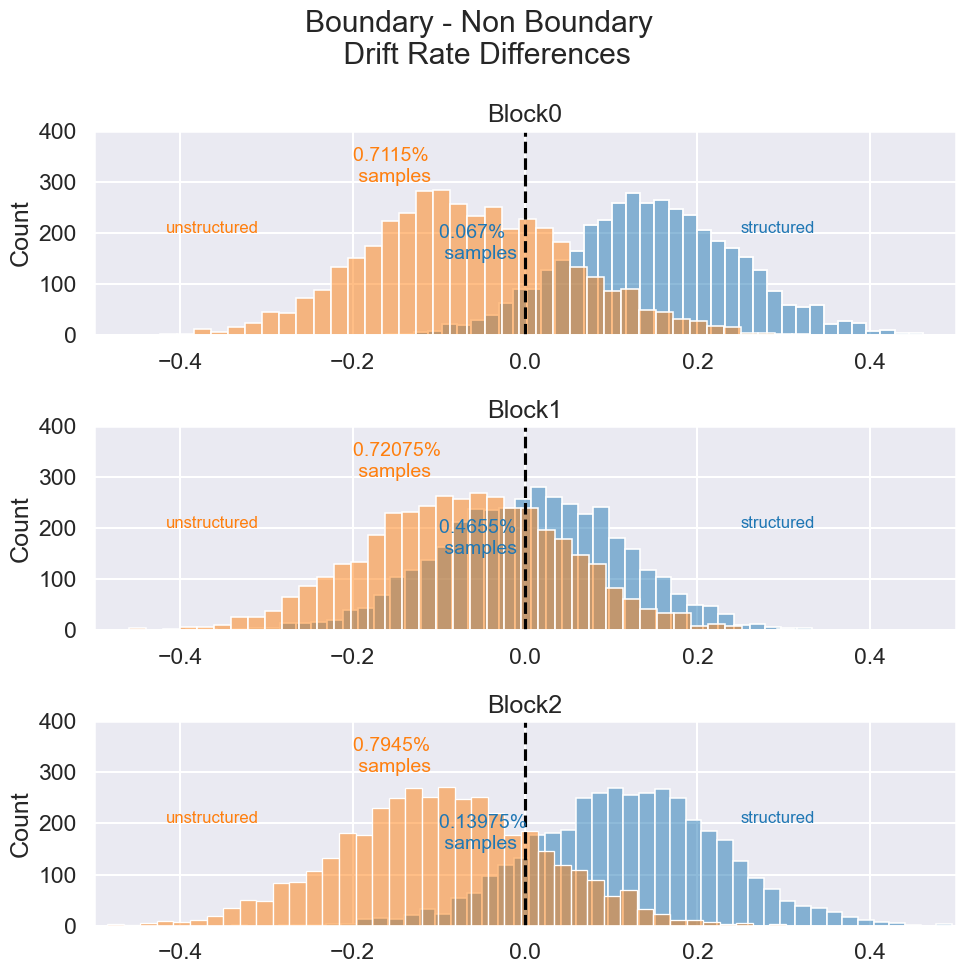

In [165]:

extracted = az.extract(samples, var_names='v_C', filter_vars='like')
blocks = range(3)
node_type = ['boundary', 'nonboundary', 'new']
conditions = ['structured', 'unstructured']
fig, ax = plt.subplots(nrows=len(blocks), figsize = (10, 10))

# sns.histplot(extracted[0], alpha = 0.5, ax = ax, label = 'New Unstructured - Boundary Structured')
for block in range(3):
    for cond in range(len(conditions)):
        sns.histplot(extracted.sel({'v_C(node_type):C(condition):C(block)_dim': f'{node_type[0]}, {conditions[cond]}, {block}'}) - extracted.sel({'v_C(node_type):C(condition):C(block)_dim': f'{node_type[1]}, {conditions[cond]}, {block}'}), label = f'{conditions[cond]}', ax = ax[block], alpha = 0.5)
        le0 = np.mean(extracted.sel({'v_C(node_type):C(condition):C(block)_dim': f'{node_type[0]}, {conditions[cond]}, {block}'}) - extracted.sel({'v_C(node_type):C(condition):C(block)_dim': f'{node_type[1]}, {conditions[cond]}, {block}'}) < 0).values
        ax[block].text(x = -0.1*(cond+1), y = 150*(cond+1), s = f"{le0}% \n samples", size = 14, color = f"C{cond}")
        ax[block].text(x = 0.25 - cond/1.5, y = 200, s = conditions[cond], size = 12, color = f"C{cond}")
    ax[block].axvline(x = 0, ls = '--', color = 'black')
    ax[block].set_title(f'Block{block}')
    ax[block].set_xlim((-0.5, 0.5))
    ax[block].set_ylim((0, 400))

handles, labels = ax[0].get_legend_handles_labels()
plt.suptitle('Boundary - Non Boundary \n Drift Rate Differences') 
# fig.legend(handles, labels, title = 'Boundary - Non Boundary', loc = 'upper right')#, bbox_to_anchor=(0.5, 0))
fig.tight_layout()
plt.savefig('figures/ddm_vdiff_bnb.png', dpi = 300, transparent = True)

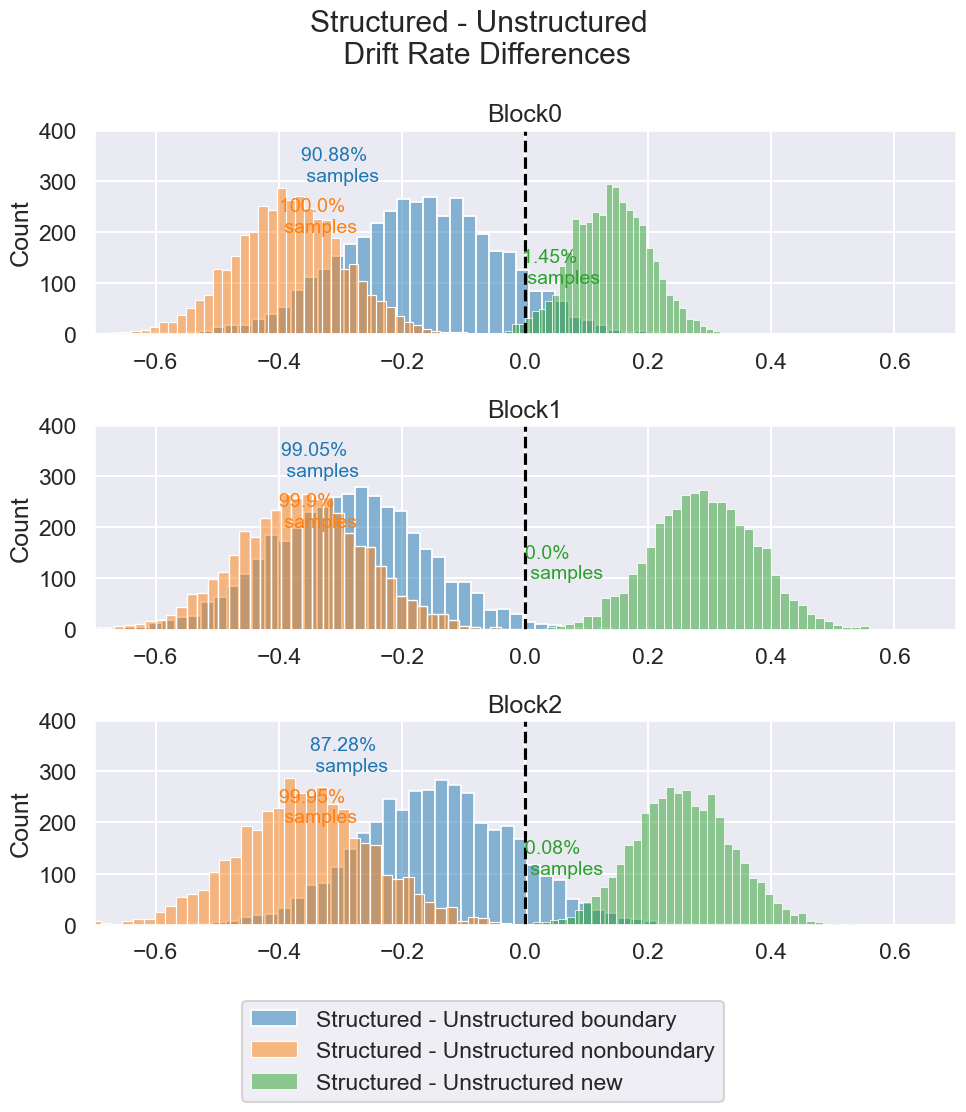

In [169]:

extracted = az.extract(samples, var_names='v_C', filter_vars='like')
blocks = range(3)
node_types = ['boundary', 'nonboundary', 'new']
conditions = ['structured', 'unstructured']
fig, ax = plt.subplots(nrows=len(blocks), figsize = (10, 10))

# sns.histplot(extracted[0], alpha = 0.5, ax = ax, label = 'New Unstructured - Boundary Structured')
for block in range(3):
    for nt in range(len(node_types)):
        sns.histplot(extracted.sel({'v_C(node_type):C(condition):C(block)_dim': f'{node_types[nt]}, {conditions[0]}, {block}'}) - extracted.sel({'v_C(node_type):C(condition):C(block)_dim': f'{node_type[nt]}, {conditions[1]}, {block}'}), label = f'Structured - Unstructured {node_types[nt]}', ax = ax[block], alpha = 0.5)
        le0 = np.mean(extracted.sel({'v_C(node_type):C(condition):C(block)_dim': f'{node_type[nt]}, {conditions[0]}, {block}'}) - extracted.sel({'v_C(node_type):C(condition):C(block)_dim': f'{node_type[nt]}, {conditions[1]}, {block}'}) < 0).values*100
        ge0 = np.mean(extracted.sel({'v_C(node_type):C(condition):C(block)_dim': f'{node_type[nt]}, {conditions[0]}, {block}'}) - extracted.sel({'v_C(node_type):C(condition):C(block)_dim': f'{node_type[nt]}, {conditions[1]}, {block}'}) > 0).values*100
        ax[block].text(x = -le0/250, y = 300 -nt*100, s = f"{round(le0, 2)}% \n samples", size = 14, color = f"C{nt}")


    ax[block].axvline(x = 0, ls = '--', color = 'black')
    ax[block].set_title(f'Block{block}')
    ax[block].set_xlim((-0.7, 0.7))
    ax[block].set_ylim((0, 400))


handles, labels = ax[0].get_legend_handles_labels()
plt.suptitle('Structured - Unstructured \n Drift Rate Differences') 
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, 0))
fig.tight_layout()
plt.savefig('figures/ddm_vdiff_suns.png', dpi = 300, transparent = True)

In [ ]:
az.summary(samples)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
a                                   1.287  0.009   1.270    1.304      0.000   
t                                   0.189  0.004   0.182    0.197      0.000   
v[0]                               -0.510  0.026  -0.559   -0.464      0.000   
v[1]                                0.667  0.033   0.603    0.727      0.000   
v[2]                               -0.510  0.026  -0.559   -0.464      0.000   
...                                   ...    ...     ...      ...        ...   
v_prior[nonboundary, structured]    0.667  0.033   0.603    0.727      0.000   
v_prior[nonboundary, unstructured]  0.981  0.037   0.911    1.047      0.001   
v_prior[boundary, structured]       0.727  0.042   0.650    0.805      0.001   
v_prior[boundary, unstructured]     0.892  0.040   0.811    0.961      0.001   
z                                   0.497  0.005   0.488    0.507      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
a                                       0.0    4157.0    2837.0    1.0  
t                                       0.0    4616.0    2858.0    1.0  
v[0]                                    0.0    4444.0    3239.0    1.0  
v[1]                                    0.0    4660.0    3488.0    1.0  
v[2]                                    0.0    4444.0    3239.0    1.0  
...                                     ...       ...       ...    ...  
v_prior[nonboundary, structured]        0.0    4660.0    3488.0    1.0  
v_prior[nonboundary, unstructured]      0.0    5283.0    3368.0    1.0  
v_prior[boundary, structured]           0.0    5008.0    3250.0    1.0  
v_prior[boundary, unstructured]         0.0    4160.0    3242.0    1.0  
z                                       0.0    3985.0    3196.0    1.0  

[5235 rows x 9 columns]

array([[<Axes: title={'center': 'v_prior'}>,
        <Axes: title={'center': 'v_prior'}>]], dtype=object)

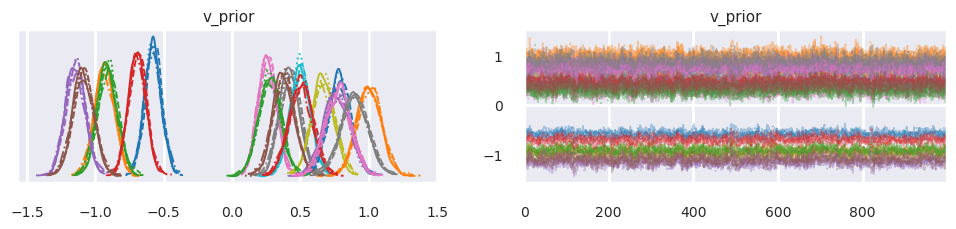

In [ ]:
az.plot_trace(samples, var_names='v_prior')

# Source Memory


In [ ]:
# Relevant Dataframe: df_clean_source_mem_joined 

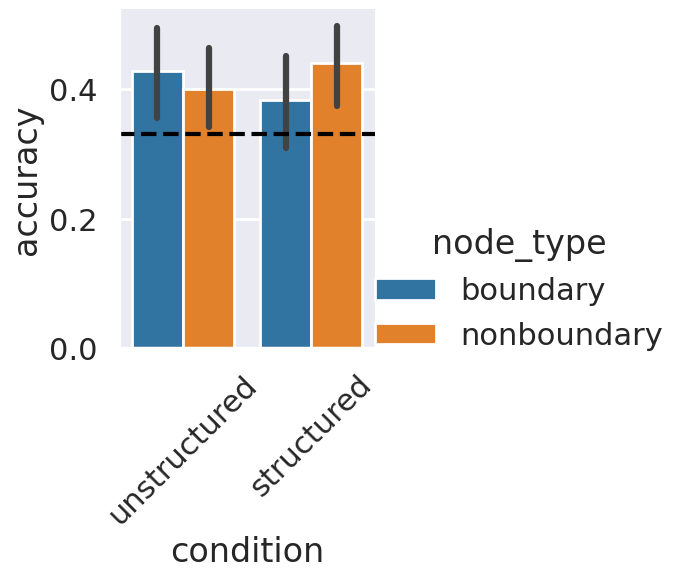

In [ ]:
g = sns.catplot(x = 'condition', y = 'accuracy', hue = 'node_type', 
           data = df_clean_source_mem_joined, kind = 'bar')
g.set_xticklabels(rotation = 45)
for i in range(1):
    g.axes[0][i].axhline(y = 0.33, ls = '--', color = 'black')

In [ ]:
ppt, mn_ppt = df_clean_source_mem_joined.participant.factorize()
nt, mn_nt = df_clean_source_mem_joined.node_type.factorize()    
cond, mn_cond = df_clean_source_mem_joined.condition.factorize()


accuracy = df_clean_source_mem_joined.accuracy
rotation_accuracy = df_clean_source_mem_joined.accuracy_exposure
coords = {"participant": mn_ppt,
          "condition": mn_cond,
          "node_type": mn_nt,
          "rotation_accuracy": rotation_accuracy
         }

with pm.Model(coords = coords) as source_mem_model:
    node_type_idx = pm.MutableData('node_type_idx', nt, dims = "obs_id")
    condition_idx = pm.MutableData('condition_idx', cond, dims = "obs_id")
    participant_idx = pm.MutableData('participant_idx', ppt, dims = "obs_id")
    
    acc_exposure_coef = pm.Normal('acc_exposure_coef', mu = 0, sigma = 1)
    cond_coef = pm.Normal('cond_coef', mu = 0, dims = 'condition')
    node_type_cond_coef = pm.Normal('node_type_cond_coef', mu = cond_coef, sigma = 1, dims = ("node_type", "condition"))
    participant_coef = pm.Normal('participant_coef', mu = 0, sigma = 1, dims = 'participant')
    logit_p = pm.Deterministic('logit_p', node_type_cond_coef[node_type_idx, condition_idx] + acc_exposure_coef*rotation_accuracy + participant_coef[participant_idx])
    y_hat = pm.Bernoulli('y_hat', logit_p=logit_p, observed = accuracy)


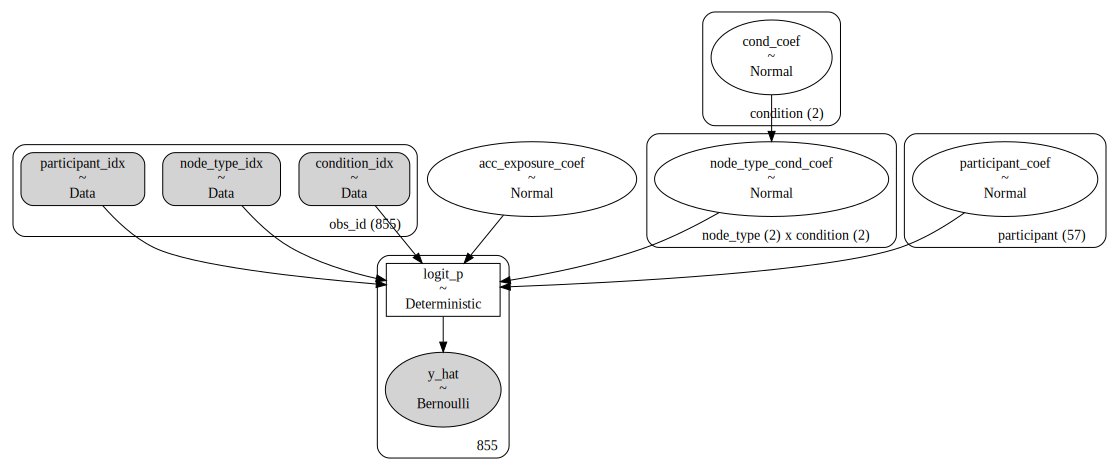

In [ ]:
pm.model_to_graphviz(source_mem_model)

In [ ]:
source_mem_model

  acc_exposure_coef ~ Normal(0, 1)
          cond_coef ~ Normal(0, 1)
node_type_cond_coef ~ Normal(cond_coef, 1)
   participant_coef ~ Normal(0, 1)
            logit_p ~ Deterministic(f(participant_coef, node_type_cond_coef, acc_exposure_coef))
              y_hat ~ Bernoulli(f(participant_coef, node_type_cond_coef, acc_exposure_coef))

In [ ]:
with source_mem_model:
    samples = pm.sample()

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━  85% 0:00:04 / 0:00:21

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


array([[<Axes: title={'center': 'acc_exposure_coef'}>,
        <Axes: title={'center': 'acc_exposure_coef'}>],
       [<Axes: title={'center': 'cond_coef'}>,
        <Axes: title={'center': 'cond_coef'}>],
       [<Axes: title={'center': 'node_type_cond_coef'}>,
        <Axes: title={'center': 'node_type_cond_coef'}>]], dtype=object)

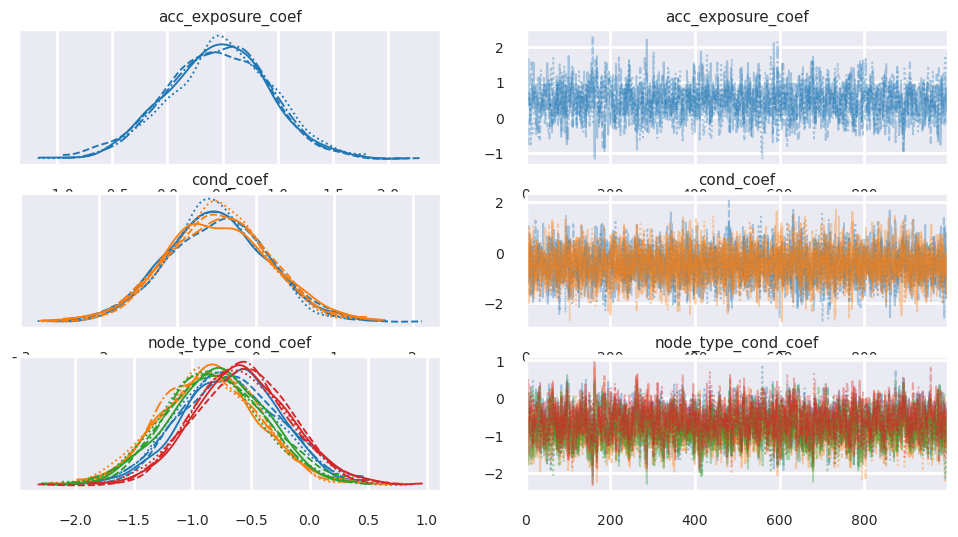

In [ ]:
az.plot_trace(samples, var_names = ['acc', 'cond'], filter_vars = 'like')

In [ ]:
az.summary(samples, var_names = ['acc', 'cond'], filter_vars = 'like')

mean     sd  hdi_3%  hdi_97%  \
acc_exposure_coef                               0.464  0.462  -0.438    1.293   
cond_coef[unstructured]                        -0.495  0.642  -1.737    0.674   
cond_coef[structured]                          -0.482  0.650  -1.678    0.712   
node_type_cond_coef[boundary, unstructured]    -0.685  0.419  -1.427    0.121   
node_type_cond_coef[boundary, structured]      -0.851  0.417  -1.579   -0.030   
node_type_cond_coef[nonboundary, unstructured] -0.805  0.416  -1.596   -0.048   
node_type_cond_coef[nonboundary, structured]   -0.582  0.402  -1.309    0.187   

                                                mcse_mean  mcse_sd  ess_bulk  \
acc_exposure_coef                                   0.014    0.010    1132.0   
cond_coef[unstructured]                             0.011    0.009    3231.0   
cond_coef[structured]                               0.012    0.010    3196.0   
node_type_cond_coef[boundary, unstructured]         0.013    0.009    1075.0   
node_type_cond_coef[boundary, structured]           0.012    0.009    1203.0   
node_type_cond_coef[nonboundary, unstructured]      0.013    0.009    1080.0   
node_type_cond_coef[nonboundary, structured]        0.012    0.009    1112.0   

                                                ess_tail  r_hat  
acc_exposure_coef                                 1894.0    1.0  
cond_coef[unstructured]                           2529.0    1.0  
cond_coef[structured]                             2786.0    1.0  
node_type_cond_coef[boundary, unstructured]       1832.0    1.0  
node_type_cond_coef[boundary, structured]         1919.0    1.0  
node_type_cond_coef[nonboundary, unstructured]    1643.0    1.0  
node_type_cond_coef[nonboundary, structured]      1810.0    1.0

In [ ]:
with source_mem_model:
    samples.extend(pm.sample_posterior_predictive(samples))

Sampling: [y_hat]


Output()

<Axes: xlabel='y_hat'>

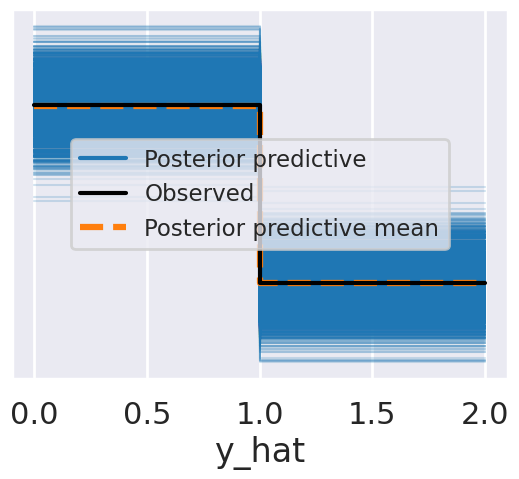

In [ ]:
az.plot_ppc(samples)

Text(0.5, 0, 'Posterior Parameter Difference')

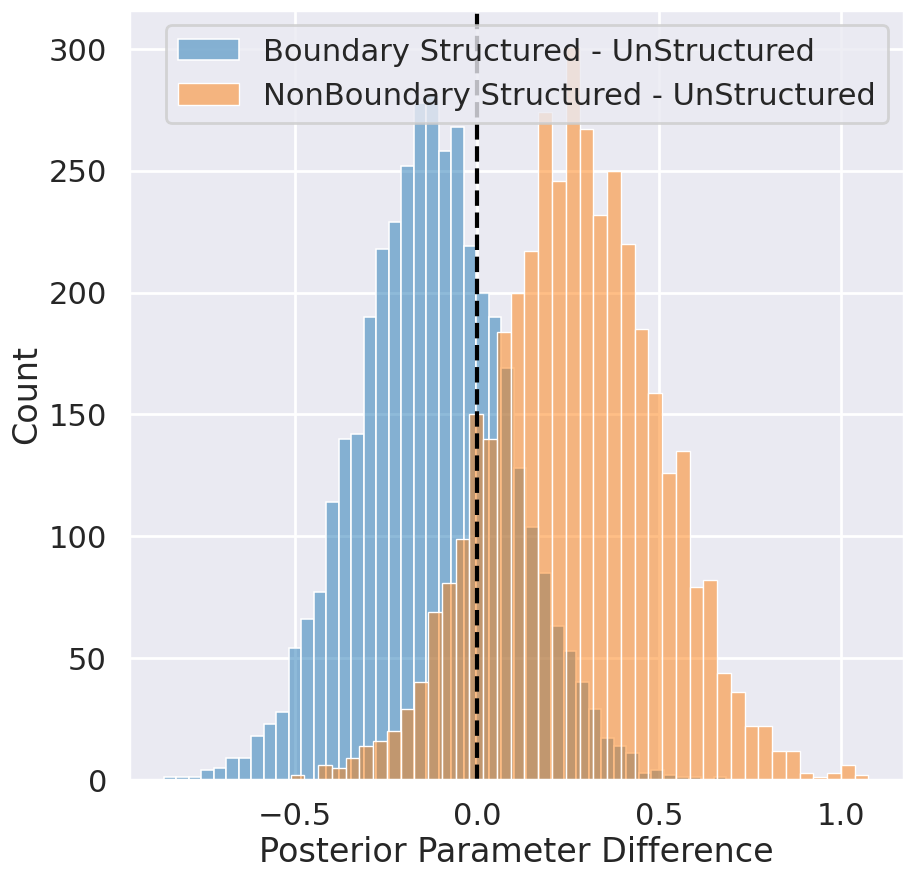

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize = (10, 10))

extracted = az.extract(samples, var_names='node_type', filter_vars='like')
sns.histplot(extracted[1, 0] - extracted[0, 0], alpha = 0.5, ax = ax, label = 'Boundary Structured - UnStructured')
sns.histplot(extracted[1, 1] - extracted[0, 1], alpha = 0.5, ax = ax, label = 'NonBoundary Structured - UnStructured')
ax.legend()
ax.axvline(x = 0, ls = '--', color = 'black')
ax.set_xlabel('Posterior Parameter Difference')
# extracted

In [ ]:
bmb_model = bmb.Model('accuracy ~ node_type:condition + (1|participant) + accuracy_exposure',family='bernoulli', data = df_clean_source_mem_joined, noncentered=True)

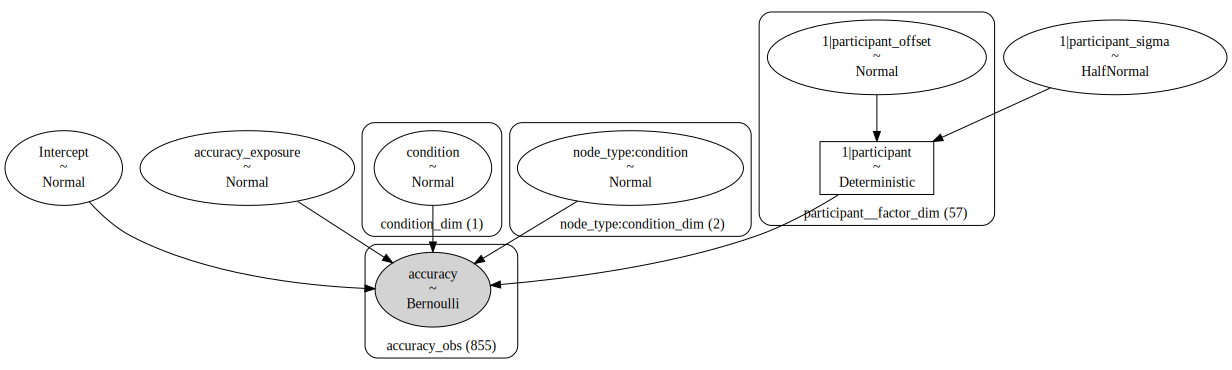

In [ ]:
bmb_model.build()
bmb_model.graph()

In [ ]:
source_mem_samples = bmb_model.fit(tune = 3000, draws = 2000)

Modeling the probability that accuracy==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, condition, node_type:condition, accuracy_exposure, 1|participant_sigma, 1|participant_offset]


Output()

In [ ]:
az.plot_forest(source_mem_samples, var_names=['acc', 'cond'], filter_vars='like', kind = 'ridgeplot')